In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

Matplotlib is building the font cache using fc-list. This may take a moment.


module://ipykernel.pylab.backend_inline


## Define some functions

In [2]:
def read_file(path, halo_num):
    data = []
    with open(path,'rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(simpath,halo_num):
    age = 13.800797497330507
    s = pynbody.load(simpath)
    s.physical_units()
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar
    
    return c_sfh, age-bincenters

## Run through all halos and calculate quenching time, infall time, and gas loss times

In [230]:
h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH.004096'
h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

path = '/home/akinshol/Data/Timescales/DataFiles/'

q_thresh = 0.99
q_lowerlim = 0.98
q_upperlim = 1.

i_thresh = 1
i_upperlim = 0.9
i_lowerlim = 1.1

i18_thresh = 1.8
i18_upperlim = 2
i18_lowerlim = 1.6

i300_thresh = 300
i300_upperlim = 250
i300_lowerlim = 350

age = 13.800797497330507

with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data','wb') as f:
    for name,simpath in zip(['h148','h242','h229','h329'],[h148,h242,h229,h329]):
        data = read_file(path+name+'.data','all')
        ids = np.unique(np.array(data.z0haloid,dtype=int))
        
        for i in ids:
            print(f'Running for simulation {name}, halo {i}',end='\t')
            
            current_data = read_file(path+name+'.data', i)
            time = np.array(current_data.time, dtype=float)
            mstar = np.array(current_data.mstar, dtype=float)[0]
            
            sSFR = np.array(current_data['sfr'][time > 13.6])[0] / mstar
            HIratio = np.array(current_data['mHI'][time > 13.6])[0] / mstar
            print(f'sSFR {sSFR}, HI richness {HIratio}')
            
            time = age - time
            
            if sSFR > 1e-11:
                is_quenched = False
            else:
                is_quenched = True
#                 print('Halo unquenched, skipping...')
#                 continue           
            
            # skip if we don't have at least 10 Gyr of data from merger trees
            if np.max(time) < 10:
                print(f'data only goes back {np.max(time):.2f} Gyr, skipping')
                continue
                
            c_sfh, bc = cumulative_sfh(simpath,i)

            dist = np.array(current_data.h1dist, dtype=float)
            gasfrac = np.array(current_data.gasfrac, dtype=float)
            HIratio = np.array(current_data.mHI,dtype=float)/np.array(current_data.mstar, dtype=float)
            mvir = np.array(current_data.mass, dtype=float)[0]

            # get quenched time
            try:
                tq = np.max(bc[c_sfh >= q_thresh])
                tq_lowerlim = np.max(bc[c_sfh >= q_lowerlim])
                tq_upperlim = np.max(bc[c_sfh >= q_upperlim])
            except:
                print('Skipping quenching time (check this!)')
                continue

            # get gas loss time
            try:
                tg = np.max(time[gasfrac < 0.01])
                tg_lowerlim = np.max(time[gasfrac < 0.05])
                tg_upperlim = np.max(time[gasfrac < 0.001])
            except ValueError:
                tg = None
                tg_lowerlim = None
                tg_upperlim = None
                
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.5:
                    th = t
                    print('Hi gas loss time %.2f' % th)
                    break
                else:
                    th = None
                    
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 1:
                    th_lowerlim = t
                    break
                else:
                    th_lowerlim = None
            
                        # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.2:
                    th_upperlim = t
                    break
                else:
                    th_upperlim = None

            # remove gas loss / HI gas loss time if there was never any gas
            if (gasfrac == 0.).all():
                tg = None
                th = None

            # get infall time
            try:
                ti = np.max(time[dist <= i_thresh])
                ti_upperlim = np.max(time[dist <= i_upperlim])
                ti_lowerlim = np.max(time[dist <= i_lowerlim])
            except ValueError:
                ti, ti_upperlim, ti_lowerlim = None, None, None
                
            try:
                t18 = np.max(time[dist <= i18_thresh])
                t18_upperlim = np.max(time[dist <= i18_upperlim])
                t18_lowerlim = np.max(time[dist <= i18_lowerlim])
            except ValueError:
                t18, t18_upperlim, t18_lowerlim = None, None, None
                
            # get 300 kpc infall time:
            if simpath==h148:
                rvir = 240*0.6776942783267969
            elif simpath==h229:
                rvir = 189*0.6776942783267969
            elif simpath==h242:
                rvir = 144*0.6776942783267969
            elif simpath==h329:
                rvir = 127*0.6776942783267969
                
            try:
                t300 = np.max(time[dist*rvir <= i300_thresh])
                t300_upperlim = np.max(time[dist*rvir <= i300_upperlim])
                t300_lowerlim = np.max(time[dist*rvir <= i300_lowerlim])
            except ValueError:
                t300, t300_lowerlim, t300_upperlim = None, None, None
            
            # calculate periapsis and apoapsis
            periapsis = np.min(dist)
            if ti is not None:
                try:
                    dist_after_infall = dist[time < ti-1] # distance values 
                    time_after_infall = time[time < ti-1]

                    apoapsis = np.max(dist_after_infall)
                    apocenter = np.argmax(dist_after_infall)


                    if time_after_infall[apocenter] == np.max(time_after_infall):
                        print('Apoapsis occurs at infall, assuming inaccuracy')
                        apoapsis = None

                    if time_after_infall[apocenter] == np.min(time_after_infall):
                        print('Apoapsis occurs at z = 0, assuming inaccuracy')
                        apoapsis = None

                    if apoapsis is not None:
                        eccentricity = (apoapsis - periapsis) / (apoapsis + periapsis)
                        print(f'eccentricity {eccentricity}')
                    else:
                        eccentricity = None
                except:
                    print('Uncaught error in eccentricity calculation')
                    apoapsis, periapsis, eccentricity = None, None, None
            else:
                apoapsis, periapsis, eccentricity = None, None, None


            print(f'tquench = {tq}, tinfall = {ti}')

#             if ti is not None:
#                 fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=300)

#                 ax[0].plot(bc,c_sfh,'r-',linewidth=2.5)
#                 ax[0].plot([tq,tq],[0,q_thresh], 'r:', linewidth=1.5)
#                 ax[0].set_xlabel('Lookback Time [Gyr]')
#                 ax[0].set_ylabel('Cumulative SFH')
#                 ax[0].invert_xaxis()

#                 ax[1].plot(time,dist,'g-',linewidth=2.5)
#                 ax[1].plot([ti,ti],[0.1,1],'g:', linewidth=1.5)
#                 ax[1].set_xlabel('Lookback Time [Gyr]')
#                 ax[1].set_ylabel('Host Distance [Rvir]')
#                 ax[1].semilogy()
#                 ax[1].invert_xaxis()

#                 ax[2].plot(time,gasfrac,'b-',linewidth=2.5)
#                 ax[2].plot([tg,tg],[0,1],'b:', linewidth=1.5)
#                 ax[2].set_xlabel('Lookback Time [Gyr]')
#                 ax[2].set_ylabel('Gas Fraction')
#                 ax[2].invert_xaxis()

#                 plt.show()

            
            pickle.dump({
                'haloid':i,
                'quenched':is_quenched,
                'tquench':tq,
                'tquench_lower':tq_lowerlim,
                'tquench_upper':tq_upperlim,
                'tinfall':ti,
                'tinfall_lower':ti_lowerlim,
                'tinfall_upper':ti_upperlim,
                't300':t300,
                't300_lower':t300_lowerlim,
                't300_upper':t300_upperlim,
                't18':t18,
                't18_lower':t18_lowerlim,
                't18_upper':t18_upperlim,
                'tHI':th,
                'tHI_lower':th_lowerlim,
                'tHI_upper':th_upperlim,
                'tgasloss':tg,
                'tgasloss_lower':tg_lowerlim,
                'tgasloss_upper':tg_upperlim,
                'M_star': mstar,
                'mass': mvir,
                'periapsis':periapsis,
                'apoapsis':apoapsis,
                'eccentricity':eccentricity,
                'sim':name                
            }, f, protocol=2)
            

Running for simulation h148, halo 2	sSFR 2.099135627258518e-10, HI richness 1.410589079391451
Hi gas loss time 0.00
Uncaught error in eccentricity calculation
tquench = 0.05299582894024368, tinfall = 0.8619607610705877
Running for simulation h148, halo 3	sSFR 6.581713304685928e-11, HI richness 0.6913728726479013
Hi gas loss time 0.00
eccentricity 0.200872721706582
tquench = 0.1595931059946576, tinfall = 3.8788234239714097
Running for simulation h148, halo 4	sSFR 5.960126773487672e-11, HI richness 0.8340117436279249


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.1569100074026899, tinfall = 1.7239215218961164
Running for simulation h148, halo 6	sSFR 1.1276344572871382e-10, HI richness 1.087457582206724
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.053058303071122026, tinfall = 2.154901902310389
Running for simulation h148, halo 7	sSFR 1.0457537366433392e-11, HI richness 0.1468360178841506
Hi gas loss time 10.77
eccentricity 0.4340207681928502
tquench = 0.8928065760237747, tinfall = 4.309803804384165
Running for simulation h148, halo 10	sSFR 1.67393207718498e-10, HI richness 3.262940609566896
Hi gas loss time 0.00
eccentricity 0.3876203128985551
tquench = 0.05379812796534367, tinfall = 5.602744945621538
Running for simulation h148, halo 11	sSFR 2.5541809791093712e-11, HI richness 0.8450446610723107
Hi gas loss time 0.00
tquench = 0.36015566867288484, tinfall = None
Running for simulation h148, halo 12	sSFR 1.3113187761465737e-12, HI 

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal


Skipping quenching time (check this!)
Running for simulation h148, halo 653	sSFR 0.0, HI richness 0.0
data only goes back 4.74 Gyr, skipping
Running for simulation h148, halo 709	sSFR 0.0, HI richness 0.0
Hi gas loss time 11.43
eccentricity 0.6521688164293946
tquench = 11.92463915176247, tinfall = 5.191966770541525
Running for simulation h148, halo 779	sSFR 0.0, HI richness 0.0
data only goes back 3.45 Gyr, skipping
Running for simulation h148, halo 901	sSFR 0.0, HI richness 0.0
data only goes back 0.43 Gyr, skipping
Running for simulation h148, halo 932	sSFR 0.0, HI richness 0.0
data only goes back 7.33 Gyr, skipping
Running for simulation h148, halo 1090	sSFR 0.0, HI richness 0.0


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/plot/stars.py:632: RuntimeWarning: divide by zero encountered in true_divide
  binnorm = 1e-9 * bins / (trange[1] - trange[0])


Skipping quenching time (check this!)
Running for simulation h242, halo 4	sSFR 4.170351290834643e-11, HI richness 0.4965134387807995
data only goes back 0.00 Gyr, skipping
Running for simulation h242, halo 10	sSFR 1.180165353119253e-11, HI richness 0.20821169394604297
data only goes back 2.48 Gyr, skipping
Running for simulation h242, halo 21	sSFR 0.0, HI richness 1.0597362850058077e-06
Hi gas loss time 4.09
tquench = 3.6050341561553196, tinfall = None
Running for simulation h242, halo 27	sSFR 0.0, HI richness 0.0
Hi gas loss time 11.53
eccentricity 0.46356632729250985
tquench = 10.659854211110952, tinfall = 8.619607608417425
Running for simulation h242, halo 31	sSFR 0.0, HI richness 0.0
Hi gas loss time 7.93
eccentricity 0.6467168045269003
tquench = 8.02887542832037, tinfall = 8.619607608417425
Running for simulation h242, halo 35	sSFR 0.0, HI richness 0.0
Hi gas loss time 1.51
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 1.6051232718944703, tinfall = 2.1549019022257117
Run

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


Skipping quenching time (check this!)
Running for simulation h329, halo 94	sSFR 0.0, HI richness 0.0
Hi gas loss time 11.53
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 12.13539719501634, tinfall = 5.387254755254723
Running for simulation h329, halo 116	sSFR 0.0, HI richness 0.0
Hi gas loss time 9.91
eccentricity 0.6917170409490928
tquench = 9.996300263992152, tinfall = 8.942842893690639
Running for simulation h329, halo 119	sSFR 0.0, HI richness 0.0
data only goes back 5.19 Gyr, skipping
Running for simulation h329, halo 131	sSFR 0.0, HI richness 0.0
Hi gas loss time 11.21
tquench = 13.548065134041693, tinfall = None
Running for simulation h329, halo 154	sSFR 0.0, HI richness 0.0
Hi gas loss time 12.18
Apoapsis occurs at infall, assuming inaccuracy
tquench = 13.088525307399474, tinfall = 9.589313464363485
Running for simulation h329, halo 443	sSFR 0.0, HI richness 0.0
data only goes back 2.80 Gyr, skipping


<Figure size 432x288 with 0 Axes>

In [232]:
data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)

In [284]:
data[(~data.quenched)&(data.M_star < 1e8)]['haloid']

6     11
8     13
9     15
10    21
53     6
68     7
Name: haloid, dtype: int64

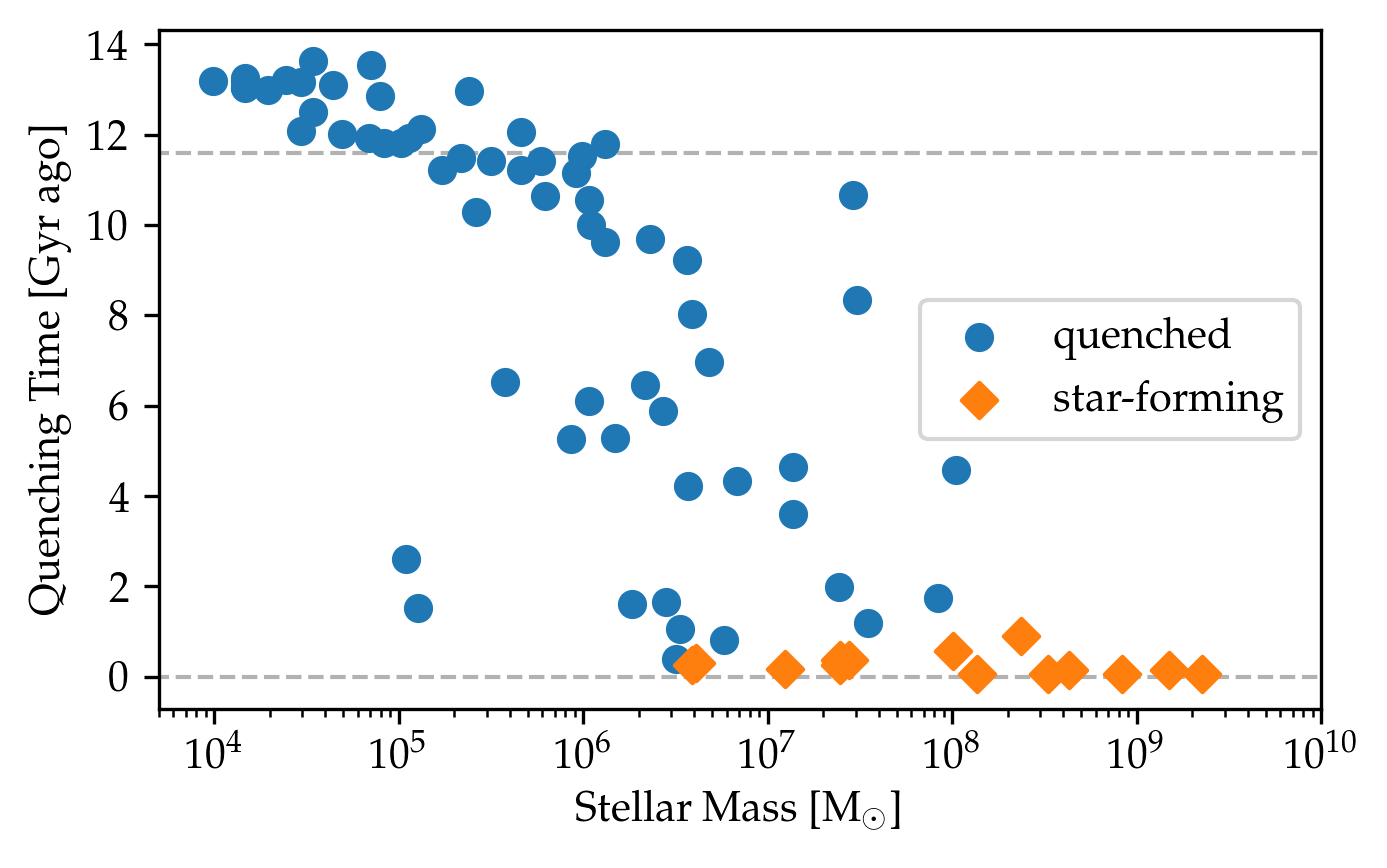

In [238]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)
q = np.array(data.quenched,dtype=bool)
ax.scatter(data.M_star[q], data.tquench[q], marker='o', zorder=1, label='quenched')
ax.scatter(data.M_star[~q], data.tquench[~q], marker='D', zorder=1, label='star-forming')


# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)
ax.plot([1e2, 1e10], [11.6,11.6], 'k--', linewidth=1, alpha=0.3, zorder=0)



ax.set_xlim(5e3,1e10)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Time [Gyr ago]')
ax.legend(frameon=True)
ax.semilogx()

plt.show()

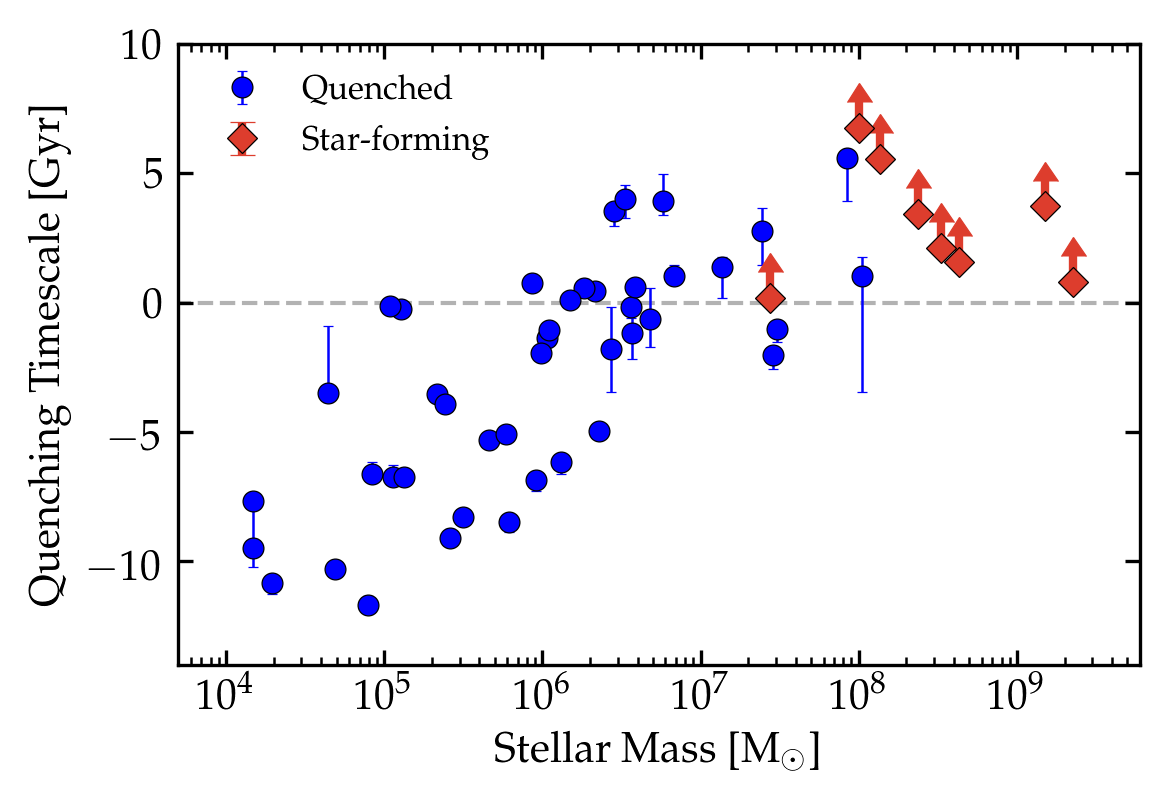

In [282]:
tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(4,2.8),dpi=300)
q = np.array(data.quenched,dtype=bool)

ax.errorbar(data.M_star[q], tinfall[q] - tquench[q],
            yerr = np.array([tau_lower_err[q], tau_upper_err[q]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='b',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            color = 'b',
            ms = 5,
            zorder=1, label='Quenched')

ax.errorbar(data.M_star[~q], tinfall[~q] - tquench[~q],
            yerr = [1]*len(tinfall[~q]),
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#DD3D2D',
            ms = 5,
            lolims=True,
            zorder=1, label='Star-forming')



# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

ax.set_xlim(5e3,6e9)
ax.set_ylim(-14, 10)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
ax.legend(frameon=False, prop={'size':8})
ax.semilogx()

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('Tq_vs_mass.png', dpi=300)

plt.show()

In [314]:
len(data[(data.tquench > 10)&(data.M_star > 1e5)])/len(data)

0.2857142857142857

In [318]:
print(data.tquench[data.M_star < 1e5])

18     12.08727568706644
20    13.187293617085075
22    12.984999149919801
26    13.181401318062733
29    11.804051041684556
34    13.027359880935114
35    12.013171547002162
49     12.86268137335407
61     13.16534215512558
62    13.244533048852013
64    13.048403778233595
67    13.631135933587684
74    13.548065134041693
75    13.088525307399474
Name: tquench, dtype: object


In [315]:
sims = ['h148', 'h242', 'h242', 'h229', 'h148', 'h229', 'h148', 'h329','h148', 'h148', 'h242', 'h148', 'h148', 'h229', 'h229', 'h329', 'h148', 'h148', 'h229', 'h148', 'h329']
ids = [90, 81, 71, 191, 189, 91, 121, 31,69, 306, 131, 52, 436, 63, 89, 94, 709, 116, 48, 438, 154]

## Plot the gas loss timescale vs stellar mass

I have defined the gas loss timescale $t_{HI} - t_{\mathrm{gas}}$ in order to see the relationship between gas loss and atomic hydrogen gas loss, which has been shown to be a good indicator of quenching. I would assume that, if quenching were dominated by stripping, we would see these points scatter around zero. But instead, we see largely positive values, indicating that hydrogen is lost before the rest of the gas is. 

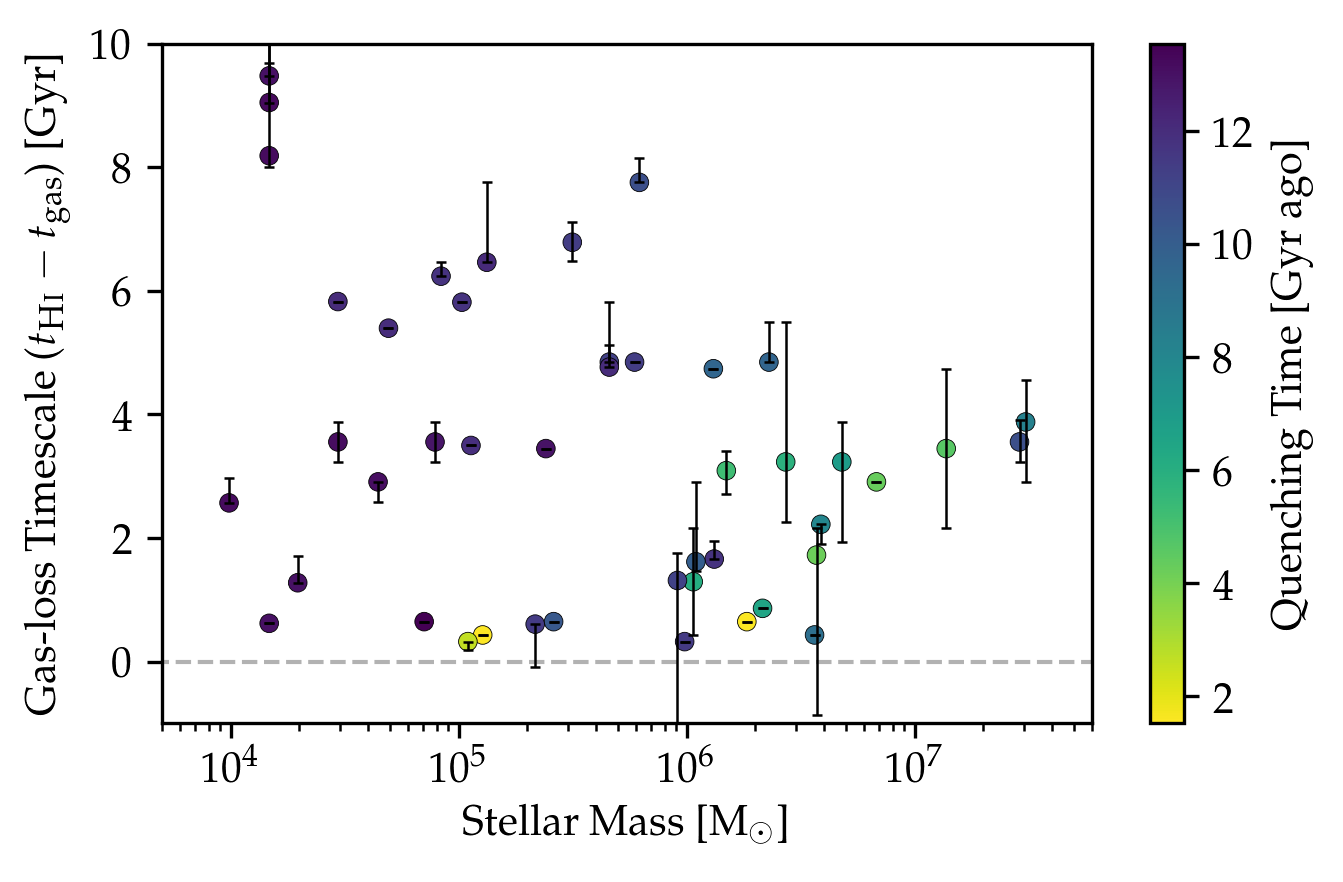

In [133]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.t300,dtype=float))]

tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgas = np.array(data.tgasloss, dtype=float)
tgas_lower = np.array(data.tgasloss_lower, dtype=float)
tgas_upper = np.array(data.tgasloss_upper, dtype=float)

tHI = np.array(data.tHI, dtype=float)
tHI_lower = np.array(data.tHI_lower, dtype=float)
tHI_upper = np.array(data.tHI_upper, dtype=float)

newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)


tgas_upper_error = np.abs(tgas_upper - tgas)
tgas_lower_error = np.abs(tgas_lower - tgas)
tHI_upper_error = np.abs(tHI_upper - tHI)
tHI_lower_error = np.abs(tHI_lower - tHI)


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)

t300 = np.array(data.t300, dtype=float)
t300_lower = np.array(data.t300_lower,dtype=float)
t300_upper = np.array(data.t300_upper,dtype=float)

newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)


upper_error = np.sqrt(tHI_upper_error**2 + tgas_upper_error**2)
lower_error = np.sqrt(tHI_lower_error**2 + tgas_lower_error**2)

ax.errorbar(mstar, tHI-tgas,
            yerr = np.array([lower_error, upper_error]),
            fmt = 'o',
            elinewidth=0.6,
            ecolor='k',
            capsize=1.2,
            capthick=0.6,
            mfc = 'none',
            mec = 'none',
            ms = 0,
            zorder = 10)

im = ax.scatter(mstar, tHI - tgas,
                c = tquench,
                s = 20,
                cmap = 'viridis_r',
                edgecolors='k',
                linewidths=0.2,
                zorder = 1)

# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Quenching Time [Gyr ago]')

ax.set_xlim(5e3,6e7)
ax.set_ylim(-1,10)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel(r'Gas-loss Timescale ($t_{\footnotesize\textsc{Hi}} - t_{\mathrm{gas}}$) [Gyr]')
# ax.legend(frameon=True,loc='lower right')
ax.semilogx()

plt.show()

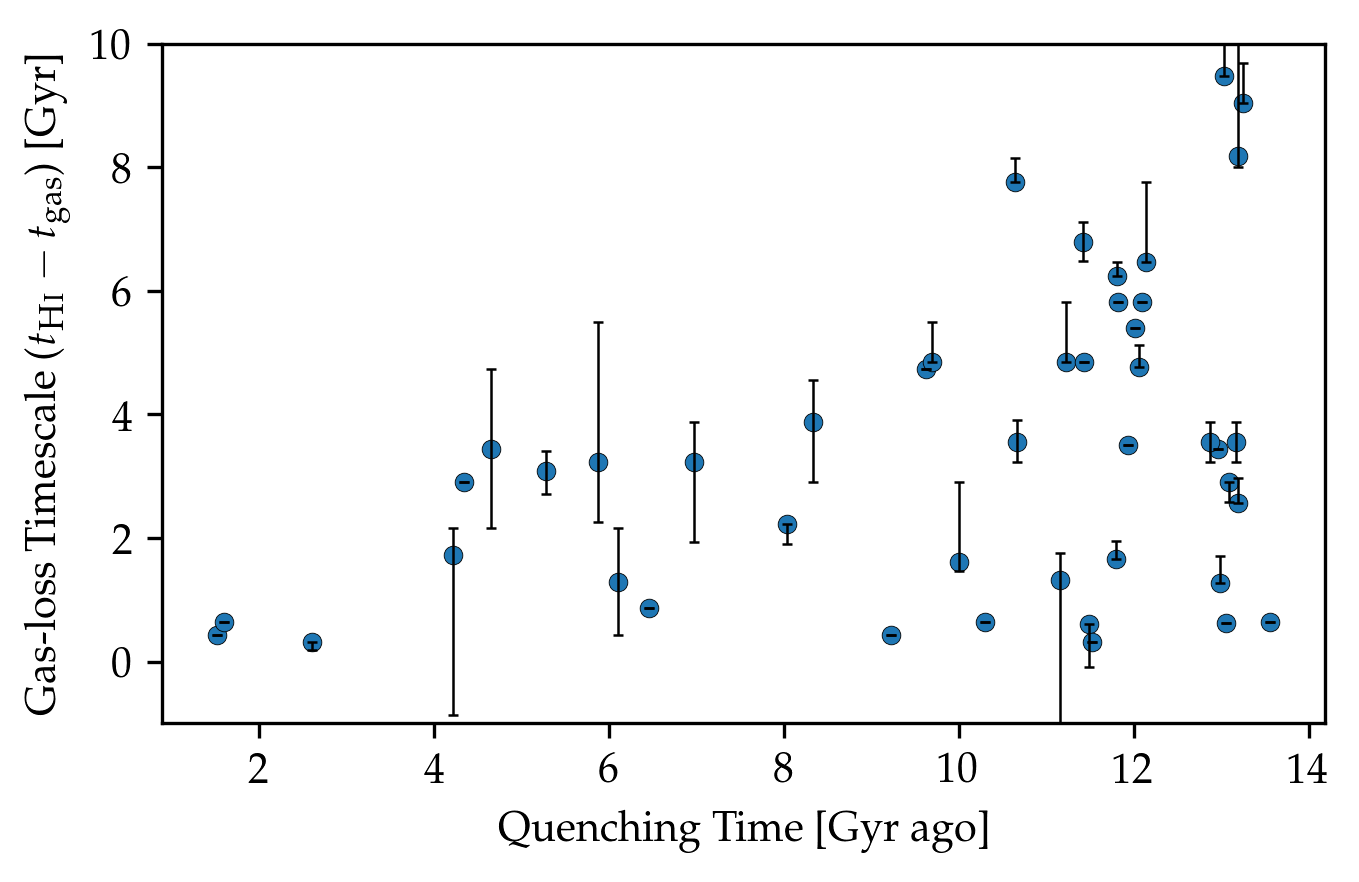

In [223]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.t300,dtype=float))]

tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgas = np.array(data.tgasloss, dtype=float)
tgas_lower = np.array(data.tgasloss_lower, dtype=float)
tgas_upper = np.array(data.tgasloss_upper, dtype=float)

tHI = np.array(data.tHI, dtype=float)
tHI_lower = np.array(data.tHI_lower, dtype=float)
tHI_upper = np.array(data.tHI_upper, dtype=float)

newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)


tgas_upper_error = np.abs(tgas_upper - tgas)
tgas_lower_error = np.abs(tgas_lower - tgas)
tHI_upper_error = np.abs(tHI_upper - tHI)
tHI_lower_error = np.abs(tHI_lower - tHI)


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)

t300 = np.array(data.t300, dtype=float)
t300_lower = np.array(data.t300_lower,dtype=float)
t300_upper = np.array(data.t300_upper,dtype=float)

newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)


upper_error = np.sqrt(tHI_upper_error**2 + tgas_upper_error**2)
lower_error = np.sqrt(tHI_lower_error**2 + tgas_lower_error**2)

ax.errorbar(tquench, tHI-tgas,
            yerr = np.array([lower_error, upper_error]),
            fmt = 'o',
            elinewidth=0.6,
            ecolor='k',
            capsize=1.2,
            capthick=0.6,
            mfc = 'none',
            mec = 'none',
            ms = 0,
            zorder = 10)

im = ax.scatter(tquench, tHI - tgas,
                s = 20,
                edgecolors='k',
                linewidths=0.2,
                zorder = 1)

# zero line
# ax.plot([1e2, 15], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

# ax.set_xlim(5e3,6e7)
ax.set_ylim(-1,10)
# ax.set_xlim(0,14)


ax.set_xlabel('Quenching Time [Gyr ago]')
ax.set_ylabel(r'Gas-loss Timescale ($t_{\footnotesize\textsc{Hi}} - t_{\mathrm{gas}}$) [Gyr]')
# ax.legend(frameon=True,loc='lower right')

plt.show()

In [205]:
print(newids[(tHI - tquench < -3)])
print(sim[(tHI - tquench < -3)])

[ 44  52  90 189  31]
['h148' 'h148' 'h148' 'h148' 'h329']


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


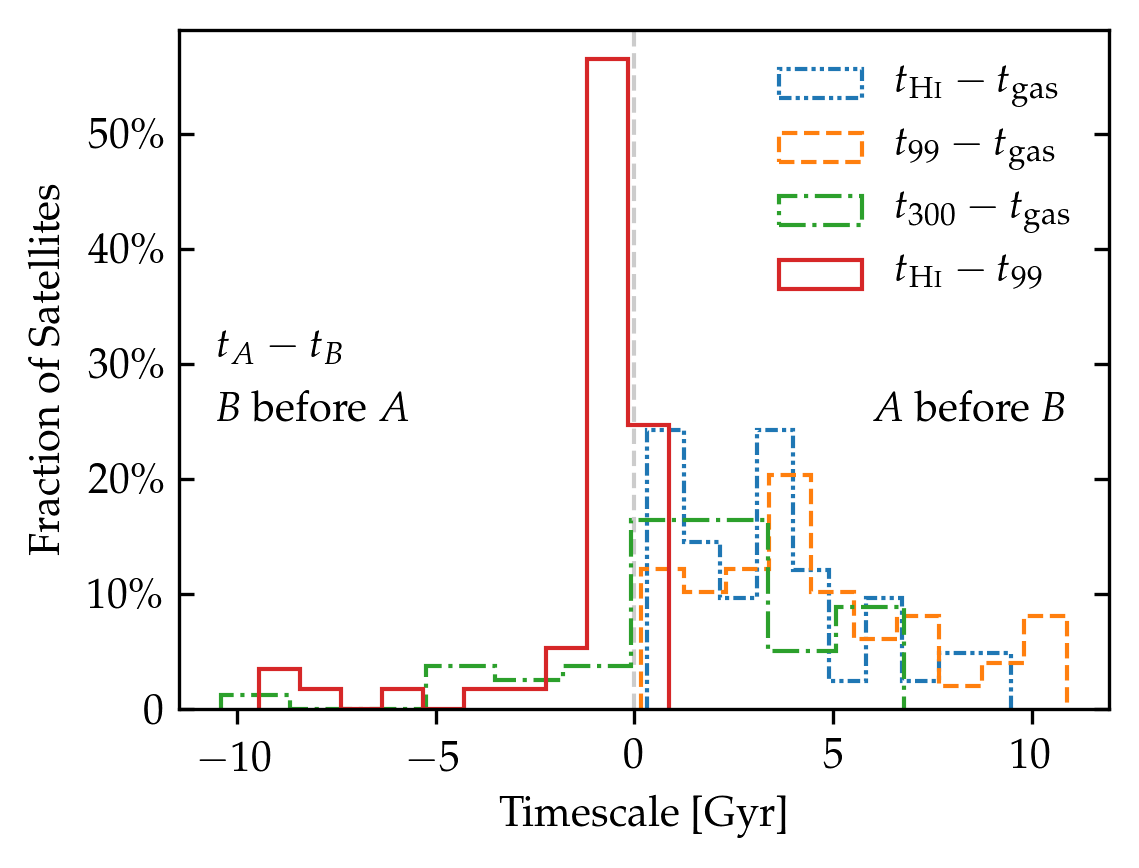

In [187]:
plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI-tgas, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1)
plt.hist(tquench - tgas, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(t300 - tgas, histtype='step', label=r'$t_{300} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1)
plt.hist(tHI - tquench, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.59)
plt.ylabel('Fraction of Satellites')
plt.xlabel('Timescale [Gyr]')
plt.legend(frameon=False)
plt.annotate(r'$t_A - t_B$', (-10.5,0.3))
plt.annotate(r'$B$ before $A$', (-10.5, 0.25),size=10)
plt.annotate(r'$A$ before $B$', (6, 0.25),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%'])

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist.png', dpi=300, bbox_inches = "tight")
plt.show()

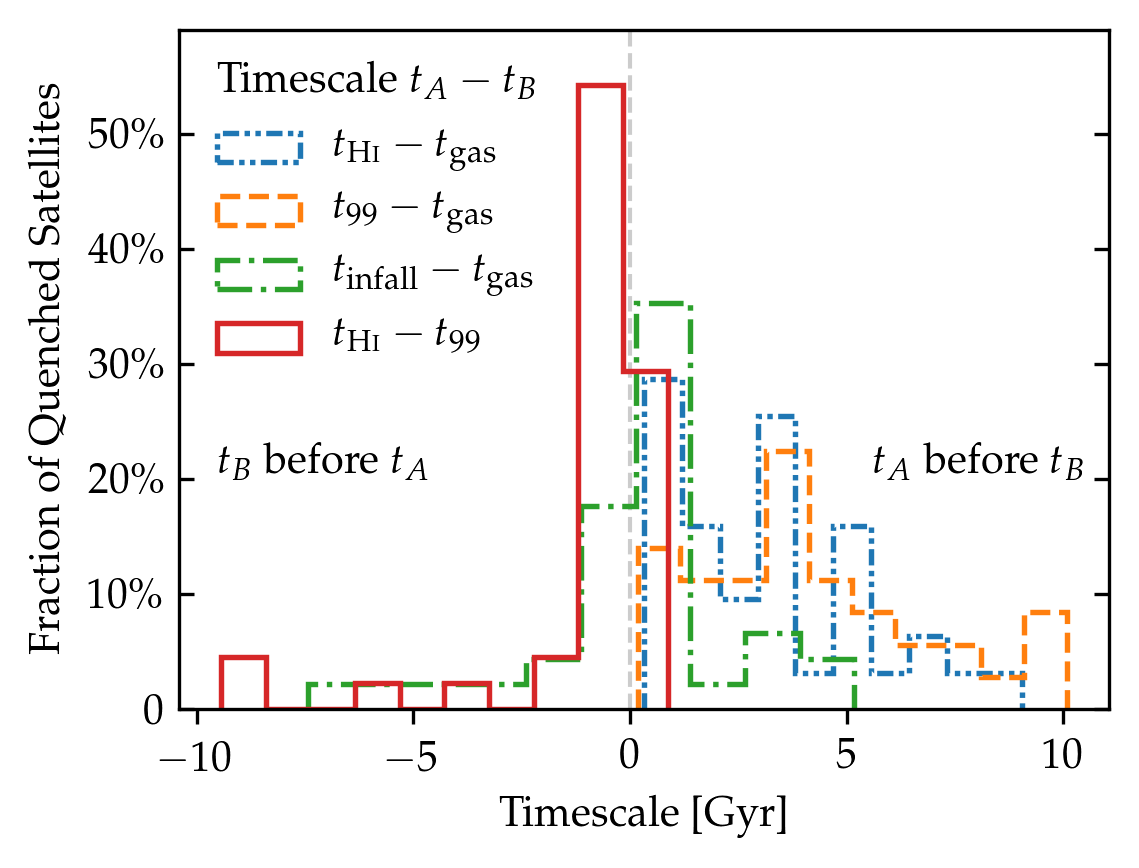

In [296]:
data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float)) & np.array(data.quenched,dtype=bool)]

tHI = np.array(data.tHI, dtype=float)
tgas = np.array(data.tgasloss, dtype=float)
tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench,dtype=float)


plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI-tgas, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1,linewidth=1.3)
plt.hist(tquench - tgas, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1,linewidth=1.3)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall - tgas, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1,linewidth=1.3)
plt.hist(tHI - tquench, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1,linewidth=1.3)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.59)
plt.ylabel('Fraction of Quenched Satellites')
plt.xlabel('Timescale [Gyr]')
leg = plt.legend(frameon=False, title=r'Timescale $t_A - t_B$', loc='upper left')
leg._legend_box.align = "left"
plt.annotate(r'$t_B$ before $t_A$', (-9.5, 0.2),size=10)
plt.annotate(r'$t_A$ before $t_B$', (5.6, 0.2),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%'])

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist.png', dpi=300, bbox_inches = "tight")
plt.show()

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


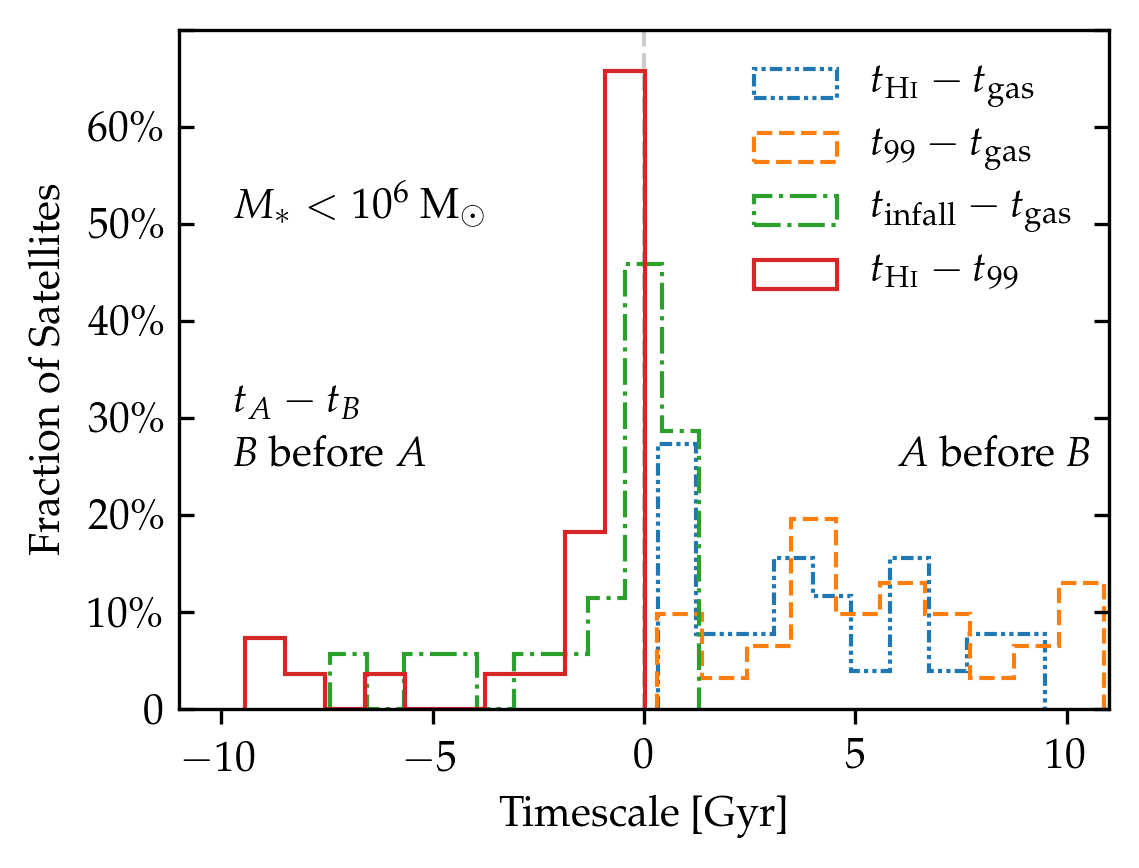

In [196]:
tHI_small = tHI[mstar < 1e6]
tgas_small = tgas[mstar < 1e6]
tquench_small = tquench[mstar < 1e6]
tinfall_small = tinfall[mstar < 1e6]

plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI_small-tgas_small, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1)
plt.hist(tquench_small - tgas_small, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall_small - tgas_small, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1)
plt.hist(tHI_small - tquench_small, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.7)
plt.ylabel('Fraction of Satellites')
plt.xlabel('Timescale [Gyr]')
plt.legend(frameon=False, title=r'$t_A - t_B')
plt.annotate(r'$M_* < 10^6\ \mathrm{M}_{\odot}$', (-9.7,0.5))
plt.annotate(r'$t_B$ before $t_A$', (-9.7, 0.25),size=10)
plt.annotate(r'$t_A$ before $t_B$', (6, 0.25),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%',r'60\%'])
plt.xlim(-11,11)
# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist.png', dpi=300, bbox_inches = "tight")
plt.show()

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


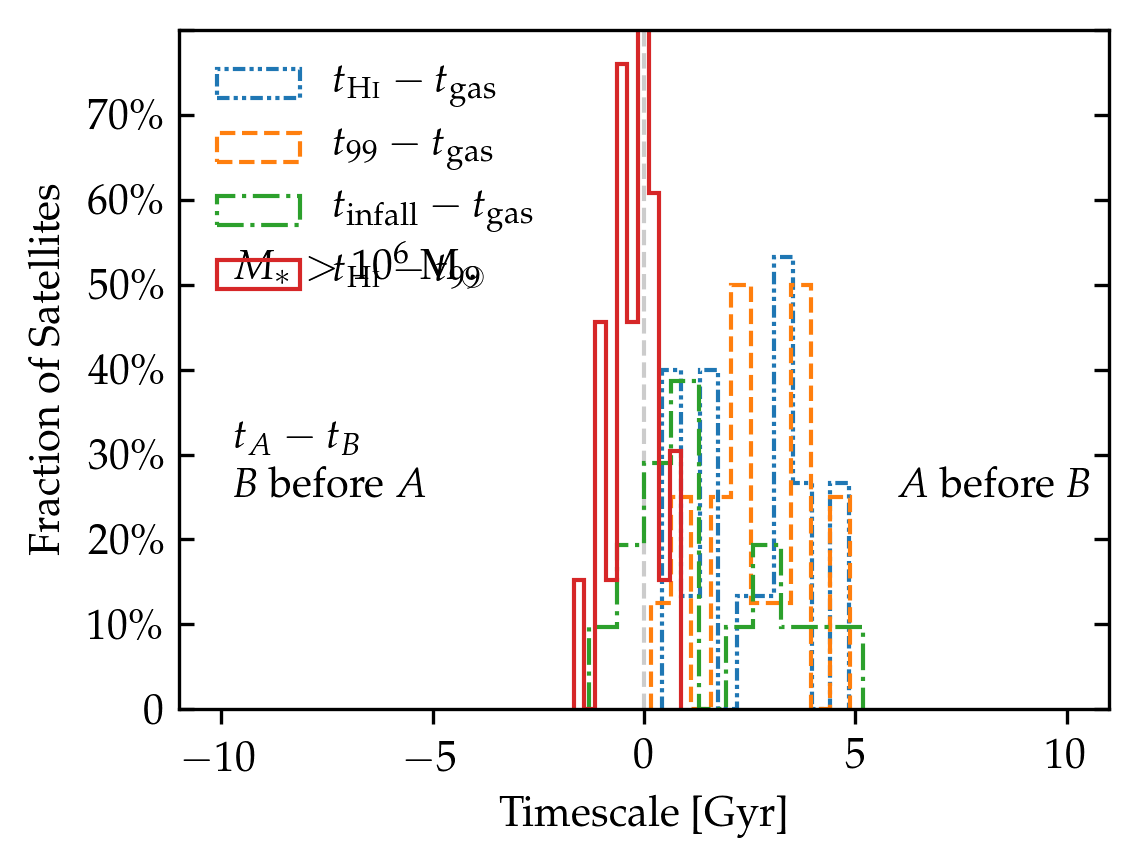

In [198]:
tHI_small = tHI[mstar > 1e6]
tgas_small = tgas[mstar > 1e6]
tquench_small = tquench[mstar > 1e6]
tinfall_small = tinfall[mstar > 1e6]

plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI_small-tgas_small, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1)
plt.hist(tquench_small - tgas_small, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall_small - tgas_small, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1)
plt.hist(tHI_small - tquench_small, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.8)
plt.ylabel('Fraction of Satellites')
plt.xlabel('Timescale [Gyr]')
plt.legend(frameon=False)
plt.annotate(r'$M_* > 10^6\ \mathrm{M}_{\odot}$', (-9.7,0.5))
plt.annotate(r'$t_A - t_B$', (-9.7,0.3))
plt.annotate(r'$B$ before $A$', (-9.7, 0.25),size=10)
plt.annotate(r'$A$ before $B$', (6, 0.25),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%',r'60\%',r'70\%'])
plt.xlim(-11,11)

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist.png', dpi=300, bbox_inches = "tight")
plt.show()

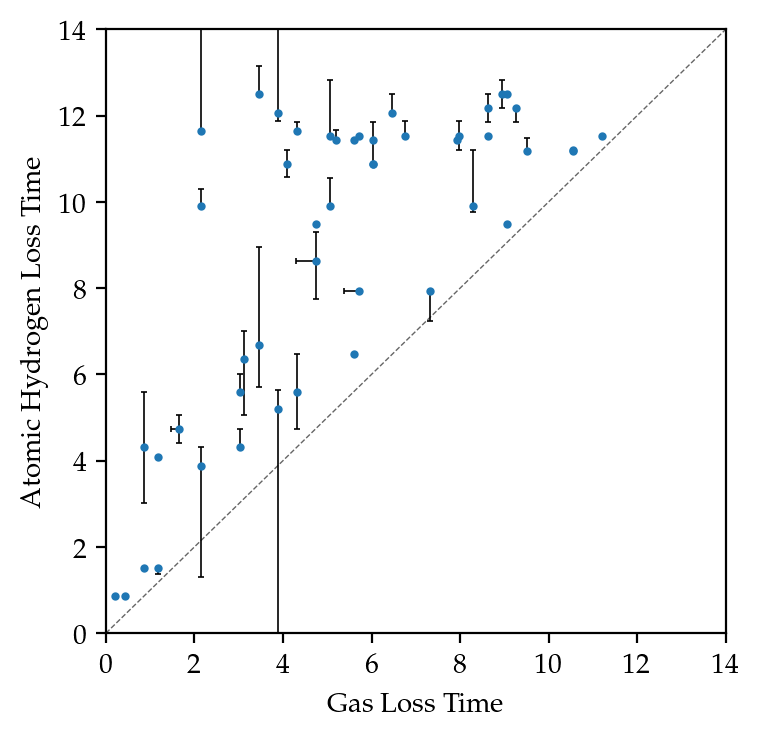

In [108]:
plt.figure(figsize=(4,4),dpi=200)
plt.errorbar(tgas, tHI, xerr=np.array([tgas_lower_error,tgas_upper_error]), yerr=np.array([tHI_lower_error,tHI_upper_error]),
             fmt='o',
             elinewidth=0.6,
             ecolor='k',
             capsize=1.2,
             capthick=0.6,
             zorder = 10,
            ms = 2)

plt.plot([0,14],[0,14],'k--', linewidth=0.5, zorder=0, alpha=0.6)

plt.xlim(0,14)
plt.ylim(0,14)
plt.ylabel('Atomic Hydrogen Loss Time')
plt.xlabel('Gas Loss Time')
plt.show()

# Quenching Time vs Infall Time

*With* simulation and halo identifiers, points colored by *stellar mass*.

Loading...	loaded data


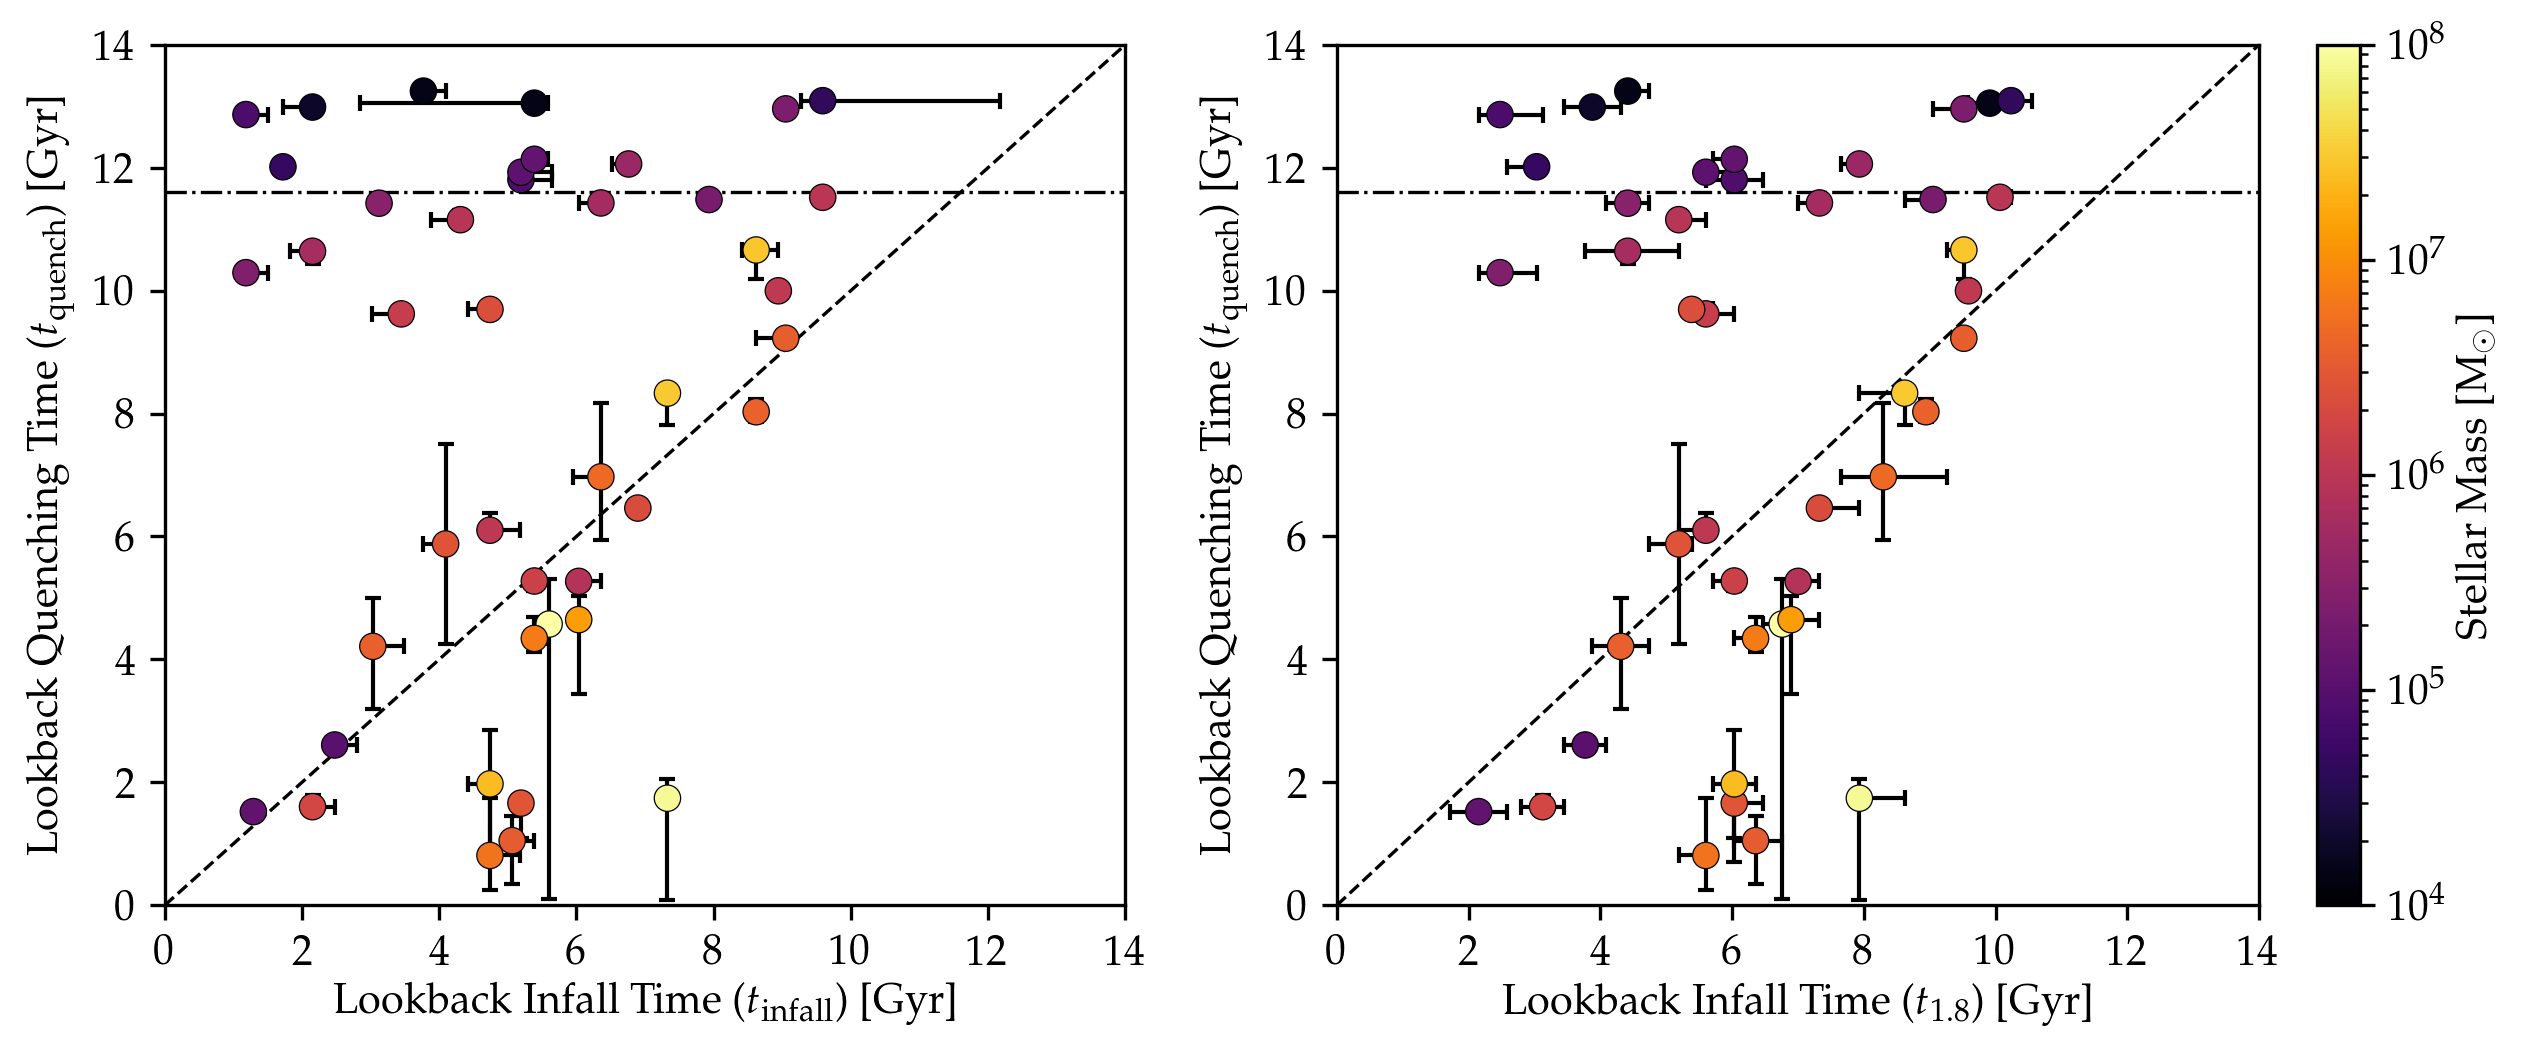

In [226]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


plt.figure(figsize=(10,3.8),dpi=300)
# we use the gridpsec module to make two subplots of varying widths so that we can have the colorbar on the side
from matplotlib.gridspec import GridSpec
gs = GridSpec(1,2,width_ratios=[5,6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
print('Loading...', end='\t')

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float))]

tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)
t18 = np.array(data.t18, dtype=float)
t18_lower = np.array(data.t18_lower,dtype=float)
t18_upper = np.array(data.t18_upper,dtype=float)
tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')



ax1.errorbar(tinfall, tquench,
                  xerr = np.array([np.abs(tinfall-tinfall_lower), np.abs(tinfall-tinfall_upper)]),
                  yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
                  fmt = 'o',
                  elinewidth=1,
                  ecolor='k',
                  capsize=2,
                  capthick=1,
                  mfc = 'none',
                  mec = 'none',
                  ms = 0,
                  zorder = 10)

im = ax1.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax1.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax1.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax1.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax1.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax1.set_xlim(0,14)
ax1.set_ylim(0,14)


# for i, (haloid, simulation) in enumerate(zip(newids, sim)):
#     if tinfall[i] != None and tquench[i] != None:
#         ax1.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)



ax2.errorbar(t18, tquench,
             xerr = np.array([np.abs(t18-t18_lower), np.abs(t18-t18_upper)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax2.scatter(t18, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax2.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax2.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax2.set_xlabel('Lookback Infall Time ($t_{\mathrm{1.8}}$) [Gyr]')
ax2.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax2.set_xlim(0,14)
ax2.set_ylim(0,14)


cbar = plt.colorbar(im, ax = ax2) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

# plt.savefig('QT_IT.png', dpi=300)
plt.show()

In [209]:
newids[mstar > 1e8]

array([12])

Loading...	loaded data


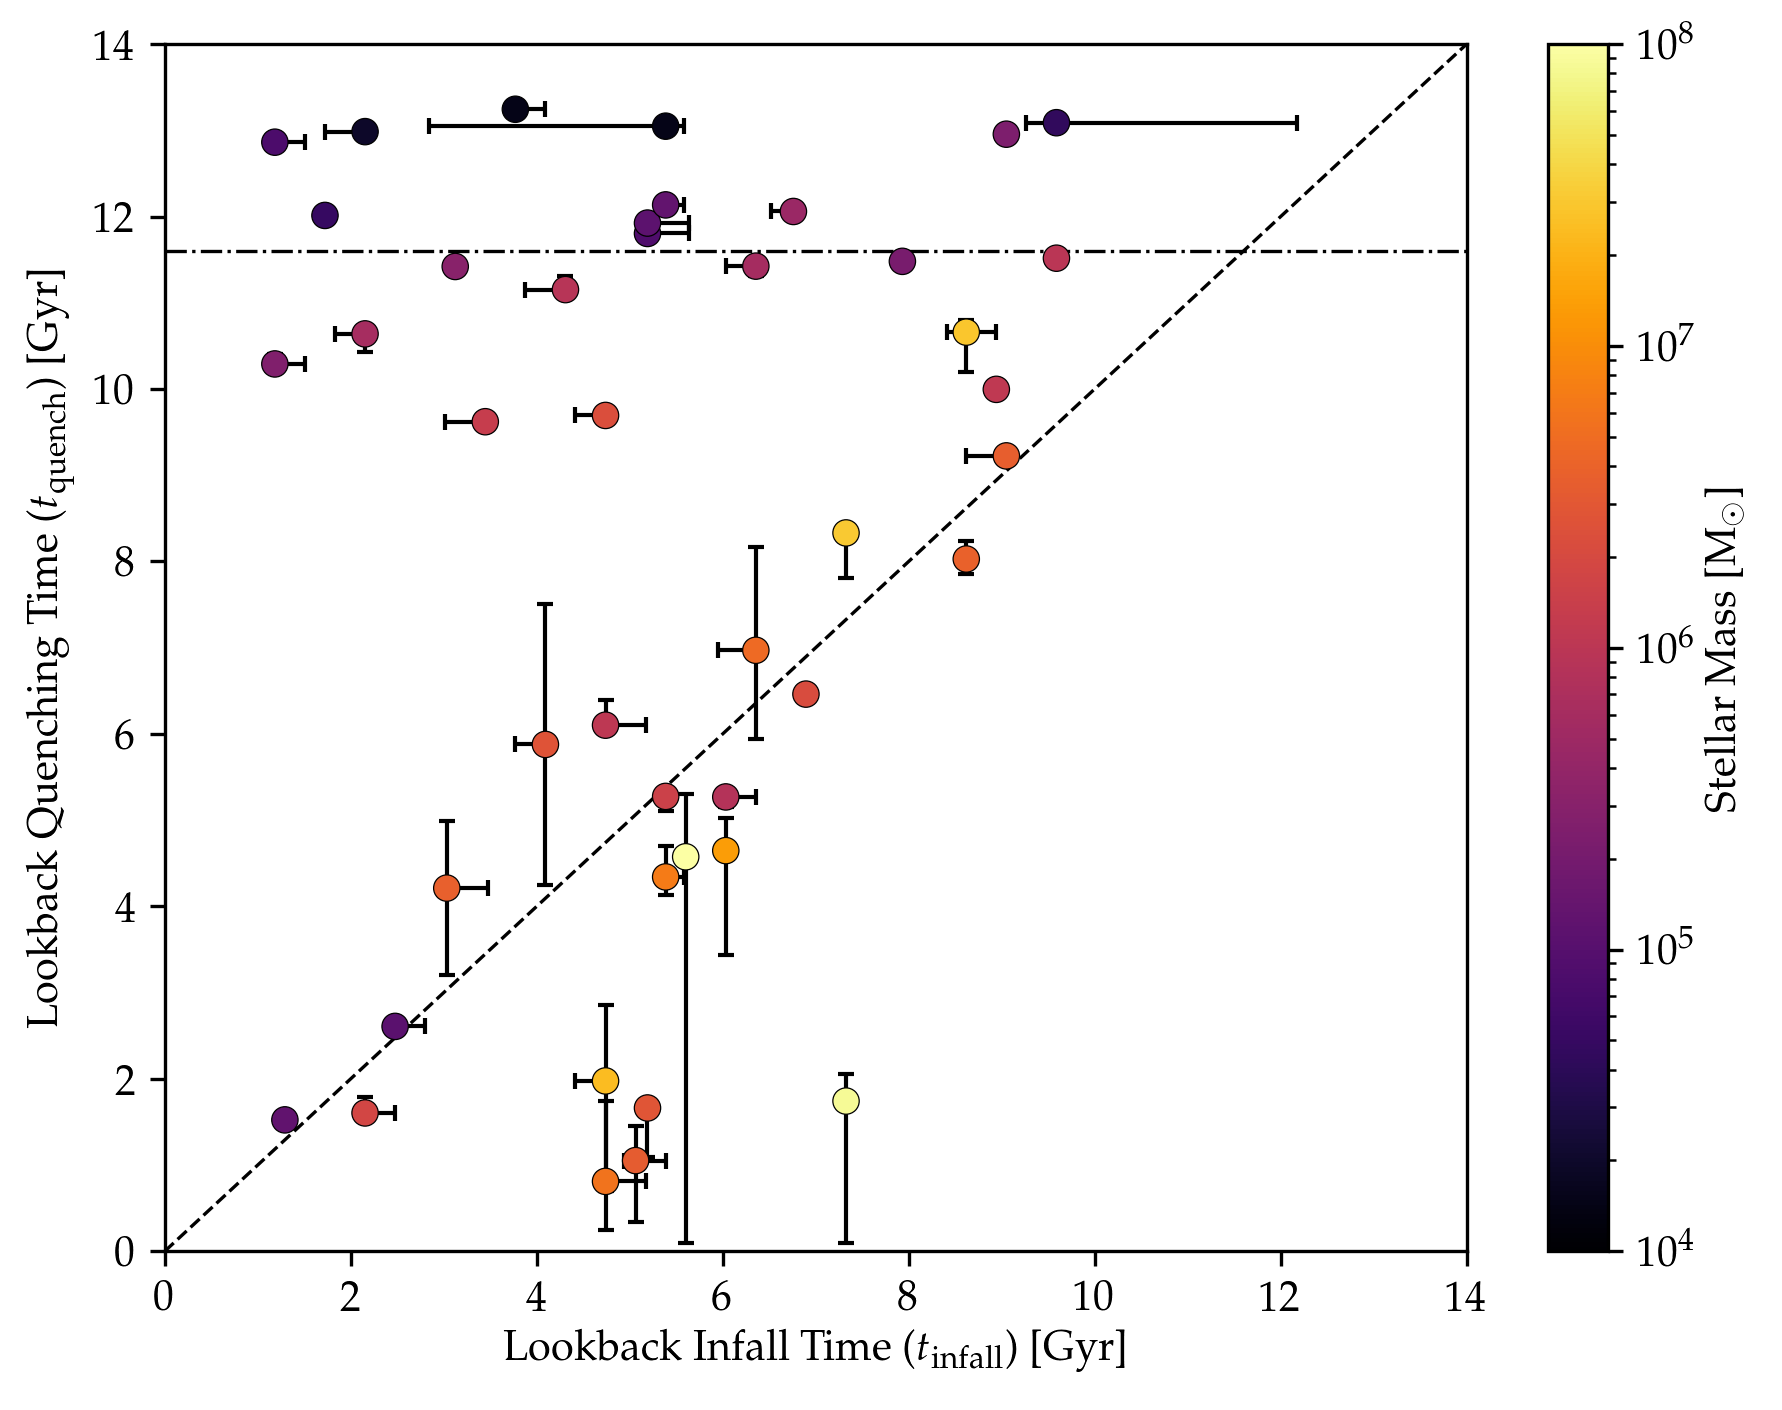

In [298]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


fig, ax = plt.subplots(1,1,figsize=(7,5.33),dpi=300)

print('Loading...', end='\t')

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[(~np.isnan(np.array(data.t300,dtype=float)))&(np.array(data.quenched,dtype=bool))]

tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)
t300 = np.array(data.t300, dtype=float)
t300_lower = np.array(data.t300_lower,dtype=float)
t300_upper = np.array(data.t300_upper,dtype=float)
tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_lower), np.abs(tinfall-tinfall_upper)]),
             yerr = np.array([np.abs(tquench-tquench_upper),np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

plt.savefig('QT_IT.png', dpi=300)
plt.show()

In [305]:
test = data[mstar < 1e6]
test = test[test.tquench < 3]
test['haloid']

17    36
69    29
Name: haloid, dtype: int64

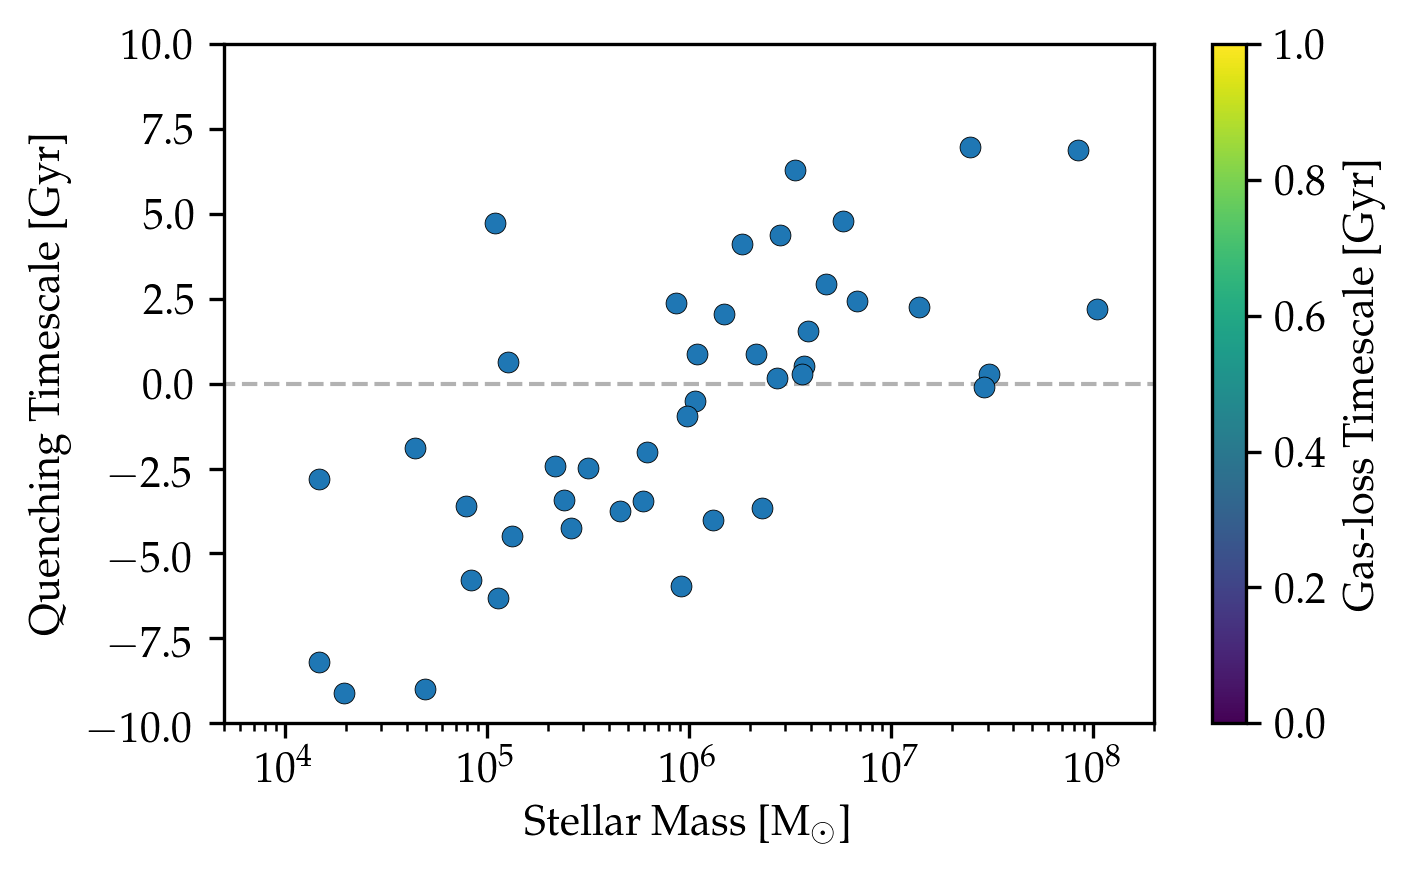

In [124]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

im = ax.scatter(mstar, t300-tquench,
#                 c=t300-tgasloss,
                s=25,
#                 cmap= 'RdYlBu',
#                 norm = mpl.colors.DivergingNorm(vmin=-6, vcenter=0, vmax=6),
                edgecolors='k',
                linewidths=0.2,
                zorder = 1)

# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Gas-loss Timescale [Gyr]')

ax.set_xlim(5e3,2e8)
ax.set_ylim(-10,10)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=True,loc='lower right')
ax.semilogx()

plt.show()

Loading...	loaded data


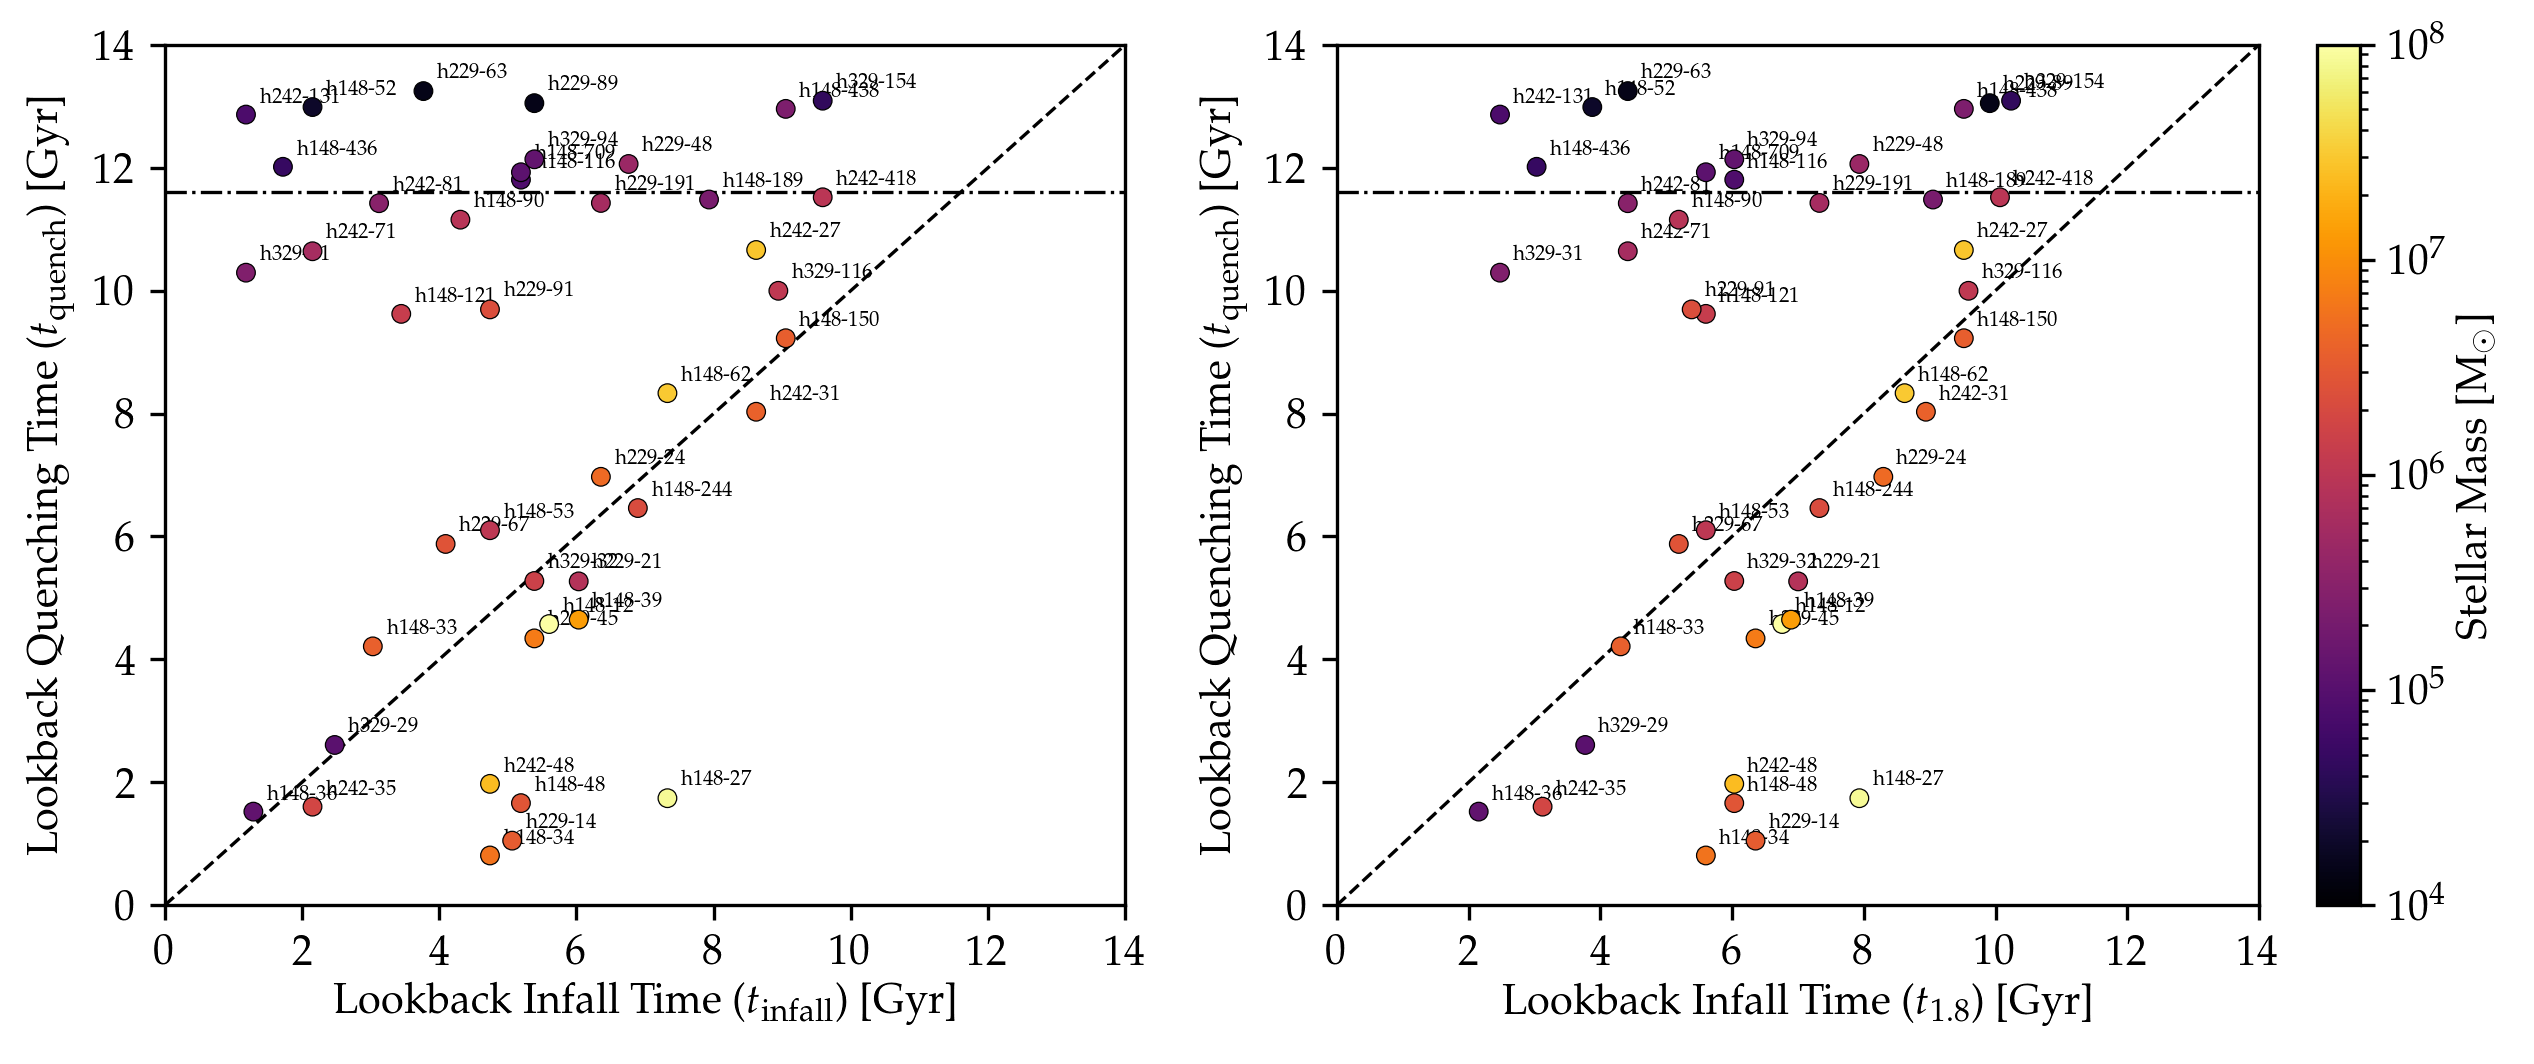

In [228]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


plt.figure(figsize=(10,3.8),dpi=300)
# we use the gridpsec module to make two subplots of varying widths so that we can have the colorbar on the side
from matplotlib.gridspec import GridSpec
gs = GridSpec(1,2,width_ratios=[5,6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
print('Loading...', end='\t')

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float))]

tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench, dtype=float)
tgasloss = np.array(data.tgasloss, dtype=float)
t18 = np.array(data.t18, dtype=float)

newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')

im = ax1.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 20,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 10)

# plot diagonal line
ax1.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax1.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax1.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax1.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax1.set_xlim(0,14)
ax1.set_ylim(0,14)


for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tquench[i] != None:
        ax1.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


im = ax2.scatter(t18, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 20,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 10)

# plot diagonal line
ax2.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax2.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax2.set_xlabel('Lookback Infall Time ($t_{\mathrm{1.8}}$) [Gyr]')
ax2.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax2.set_xlim(0,14)
ax2.set_ylim(0,14)

for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tgasloss[i] != None:
        ax2.annotate(str(simulation)+'-'+str(int(haloid)), (t18[i]+0.2, tquench[i]+0.2), size=5)

cbar = plt.colorbar(im, ax = ax2) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

plt.savefig('QT_IT_ids.png',dpi=300)
plt.show()

# Quenching Time vs Infall Time

*Without* simulation and halo identifiers, points colored by *stellar mass*.

Loading...	loaded data


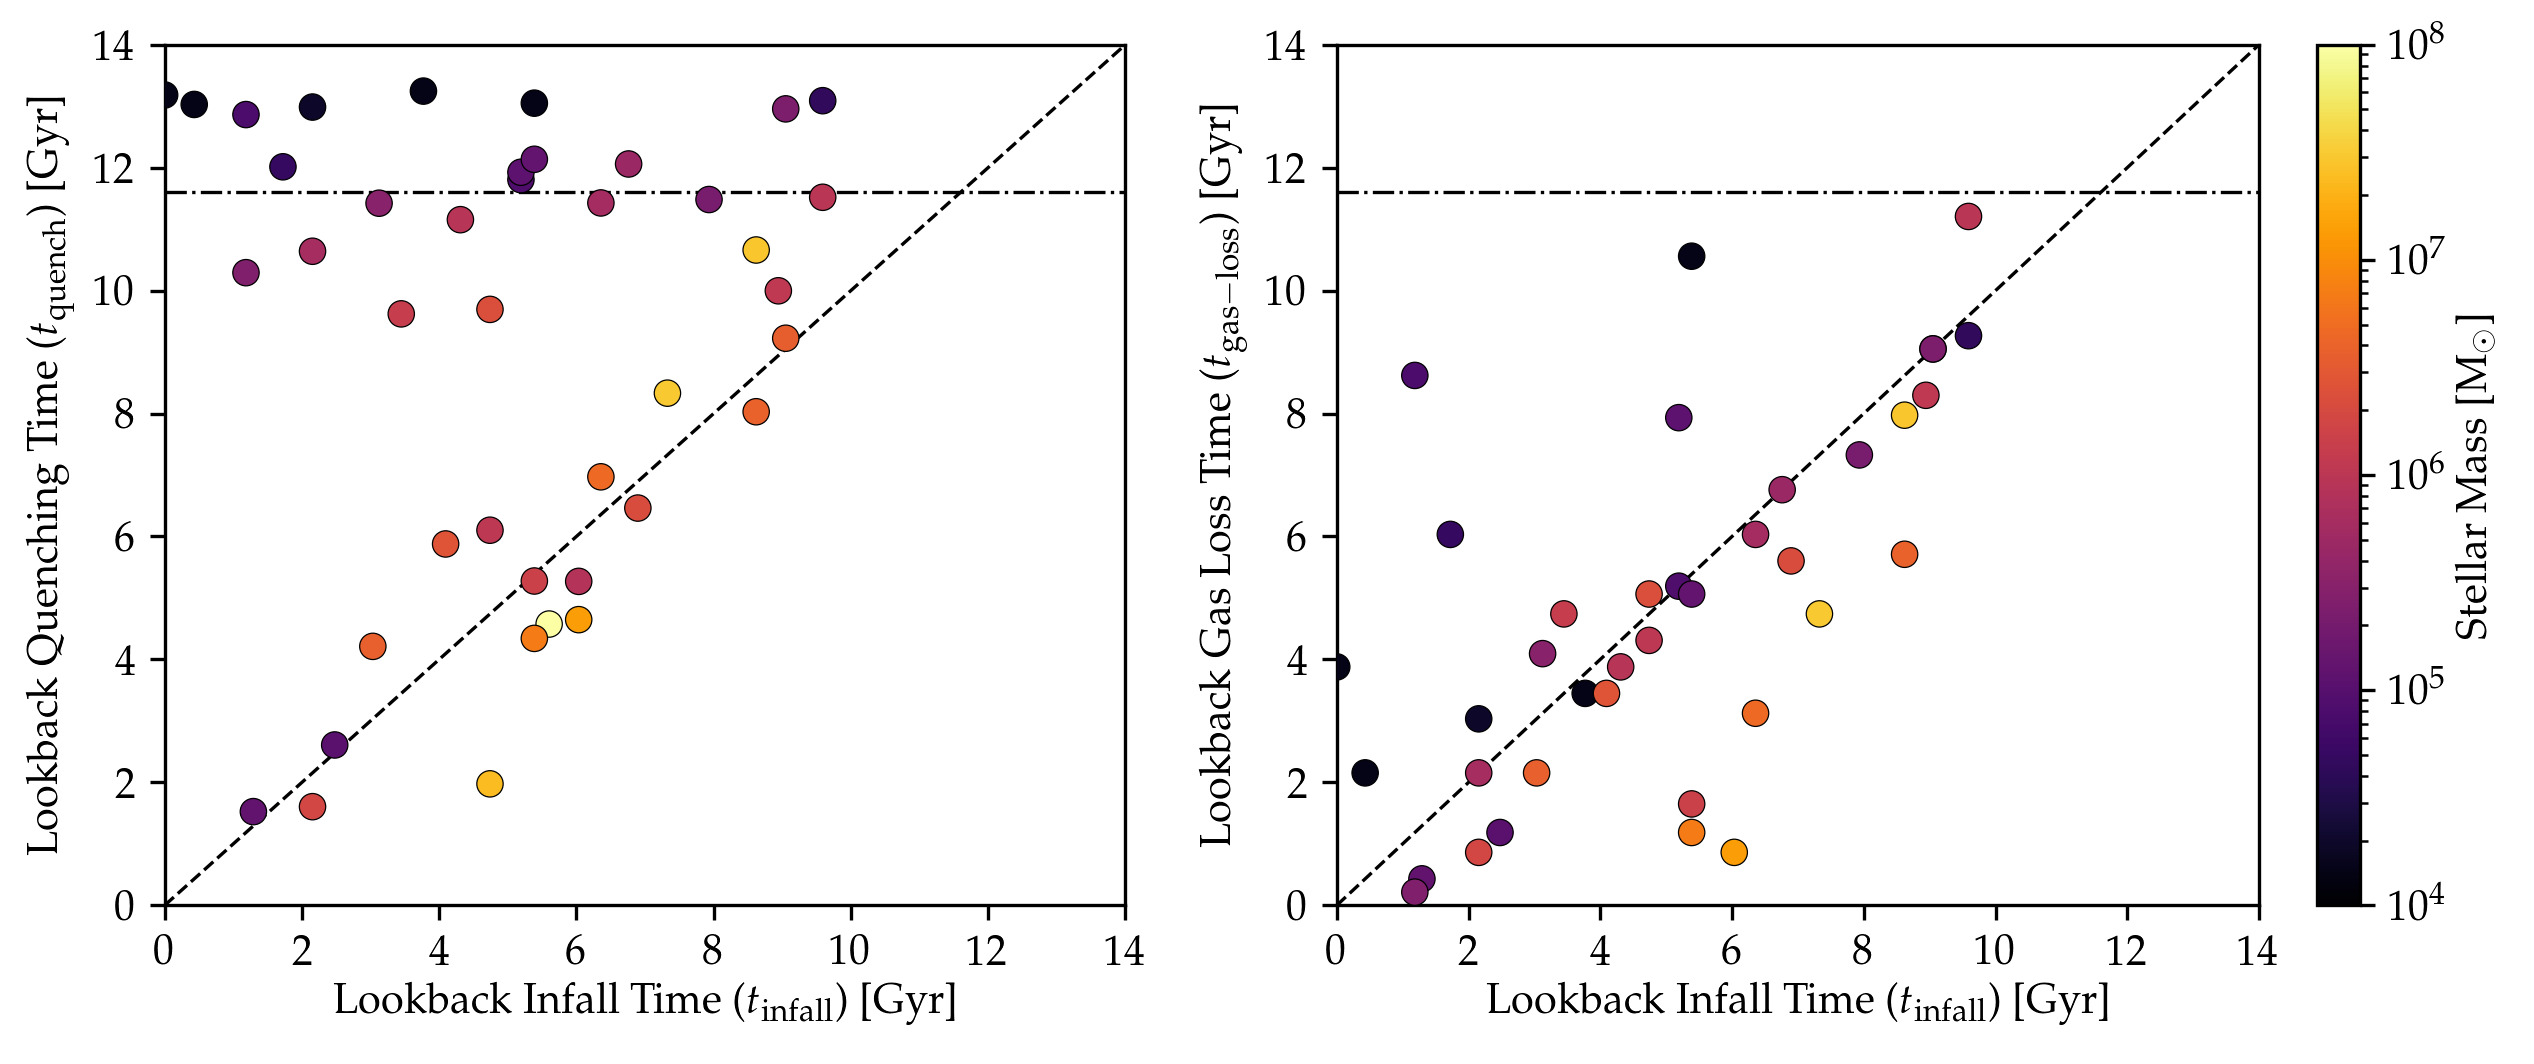

In [24]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


plt.figure(figsize=(10,3.8),dpi=300)
# we use the gridpsec module to make two subplots of varying widths so that we can have the colorbar on the side
from matplotlib.gridspec import GridSpec
gs = GridSpec(1,2,width_ratios=[5,6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
print('Loading...', end='\t')

data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float))]

tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench, dtype=float)
tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')

im = ax1.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 10)

# plot diagonal line
ax1.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax1.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax1.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax1.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax1.set_xlim(0,14)
ax1.set_ylim(0,14)


# for i, (haloid, simulation) in enumerate(zip(newids, sim)):
#     if tinfall[i] != None and tquench[i] != None:
#         ax1.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


im = ax2.scatter(tinfall, tgasloss,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 10)

# plot diagonal line
ax2.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax2.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax2.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax2.set_ylabel('Lookback Gas Loss Time ($t_{\mathrm{gas-loss}}$) [Gyr]')
ax2.set_xlim(0,14)
ax2.set_ylim(0,14)

# for i, (haloid, simulation) in enumerate(zip(newids, sim)):
#     if tinfall[i] != None and tgasloss[i] != None:
#         ax2.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tgasloss[i]+0.2), size=5)

cbar = plt.colorbar(im, ax = ax2) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

plt.savefig('QT_IT.png', dpi=300)
plt.show()

# Quenching Time vs Infall Time

*With* simulation and halo identifiers, points colored by *virial mass*.

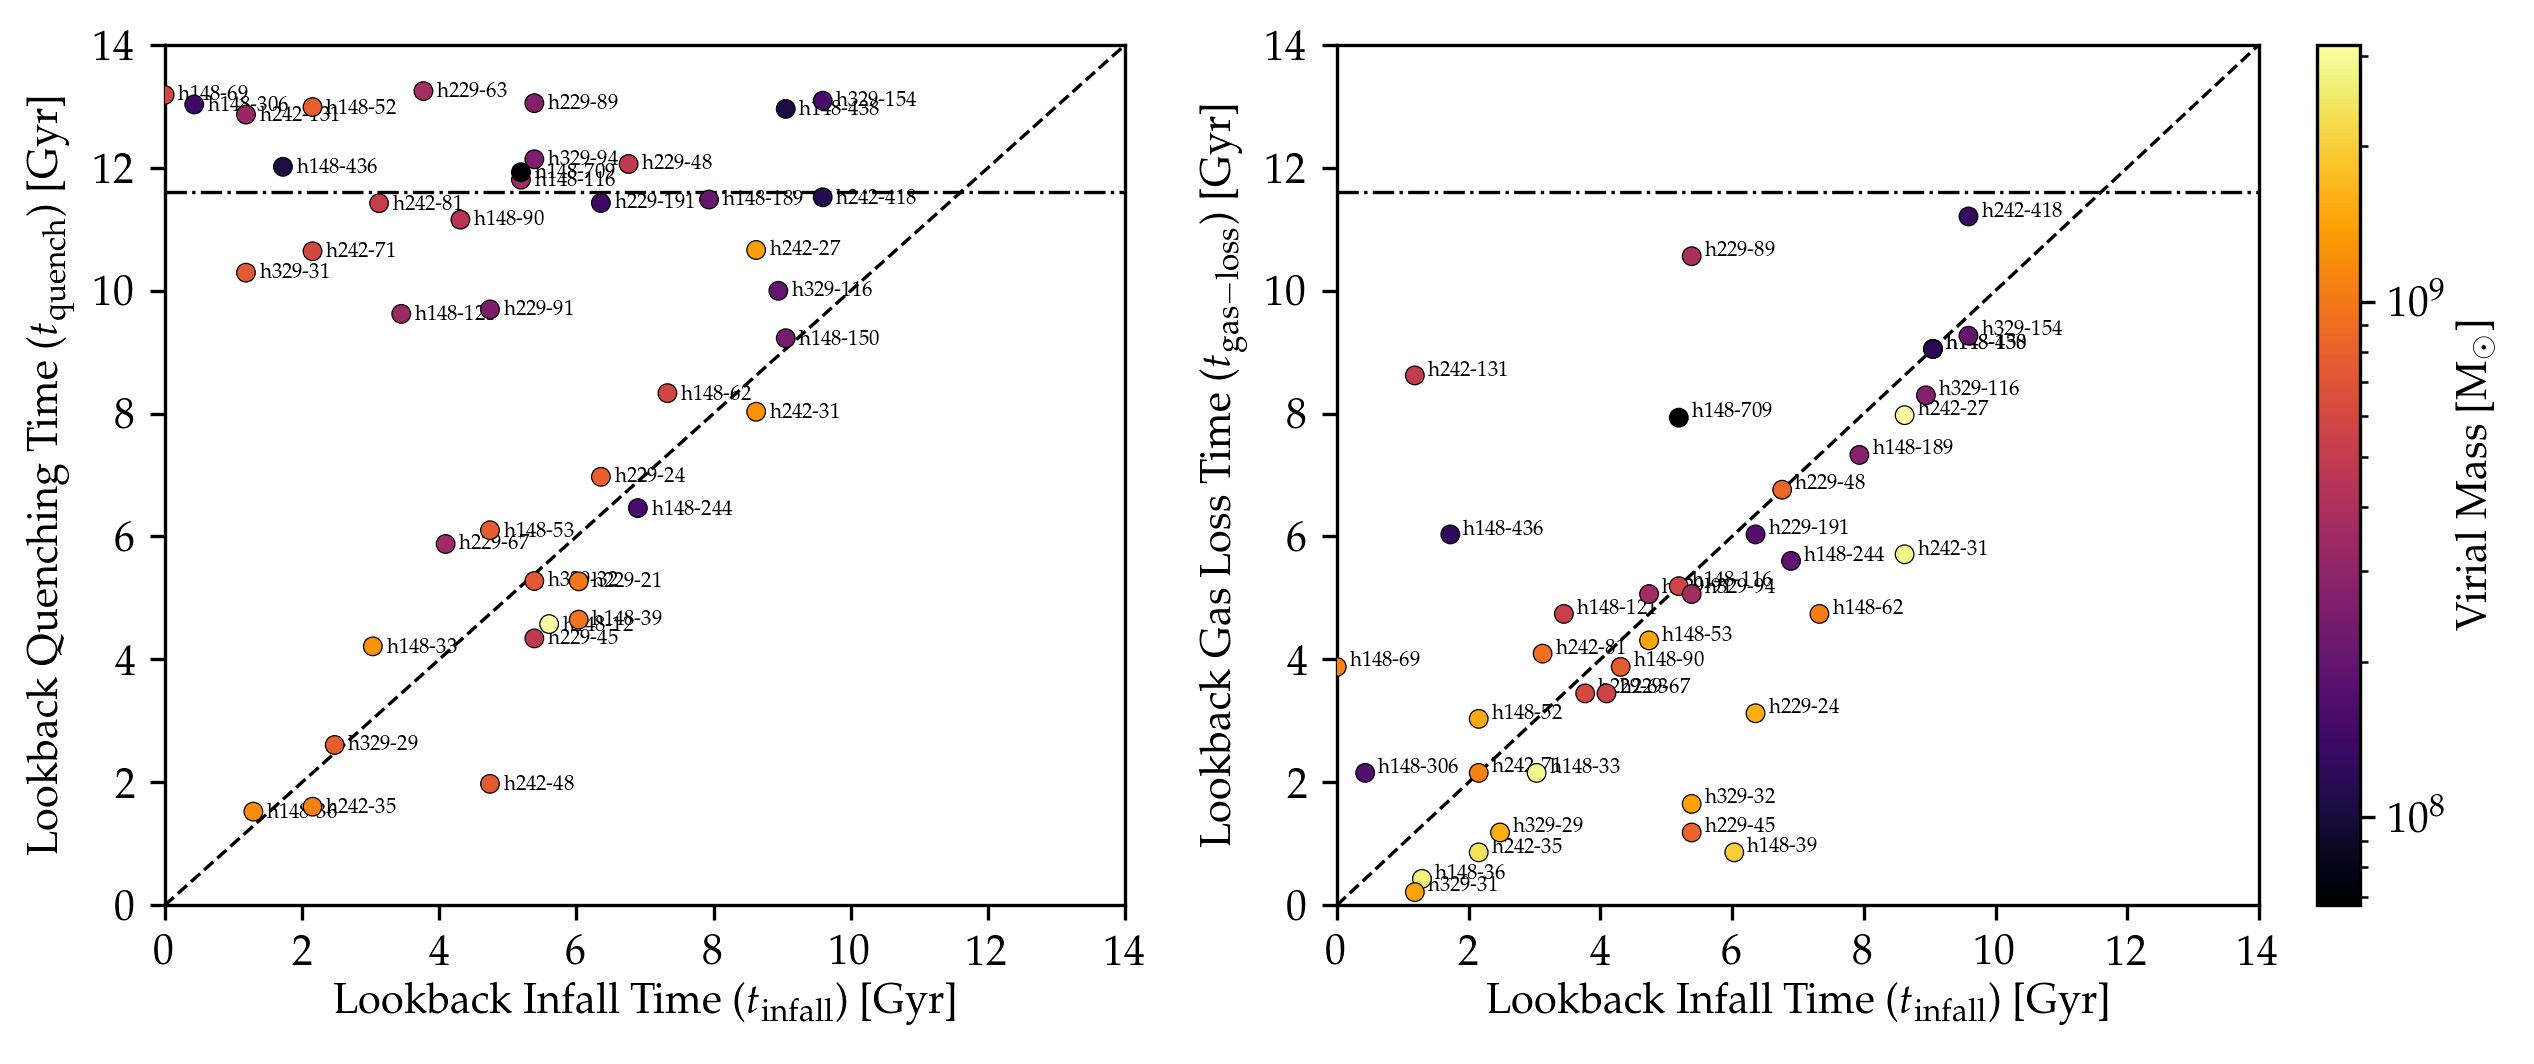

In [5]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


plt.figure(figsize=(10,3.8),dpi=300)
# we use the gridpsec module to make two subplots of varying widths so that we can have the colorbar on the side
from matplotlib.gridspec import GridSpec
gs = GridSpec(1,2,width_ratios=[5,6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float))]

tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench, dtype=float)
tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
# mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)


im = ax1.scatter(tinfall, tquench,
                 c = mvir,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 20,
                 zorder = 10)
# plot diagonal line
ax1.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax1.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax1.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax1.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax1.set_xlim(0,14)
ax1.set_ylim(0,14)

for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tquench[i] != None:
        ax1.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]-0.1), size=5)

im = ax2.scatter(tinfall, tgasloss,
                 c = mvir,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 20,
                 zorder = 10)
# plot diagonal line
ax2.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax2.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax2.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax2.set_ylabel('Lookback Gas Loss Time ($t_{\mathrm{gas-loss}}$) [Gyr]')
ax2.set_xlim(0,14)
ax2.set_ylim(0,14)

for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tgasloss[i] != None:
        ax2.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tgasloss[i]), size=5)

cbar = plt.colorbar(im, ax = ax2) 
cbar.ax.set_ylabel(r'Virial Mass [$\mathrm{M}_{\odot}$]')

plt.show()

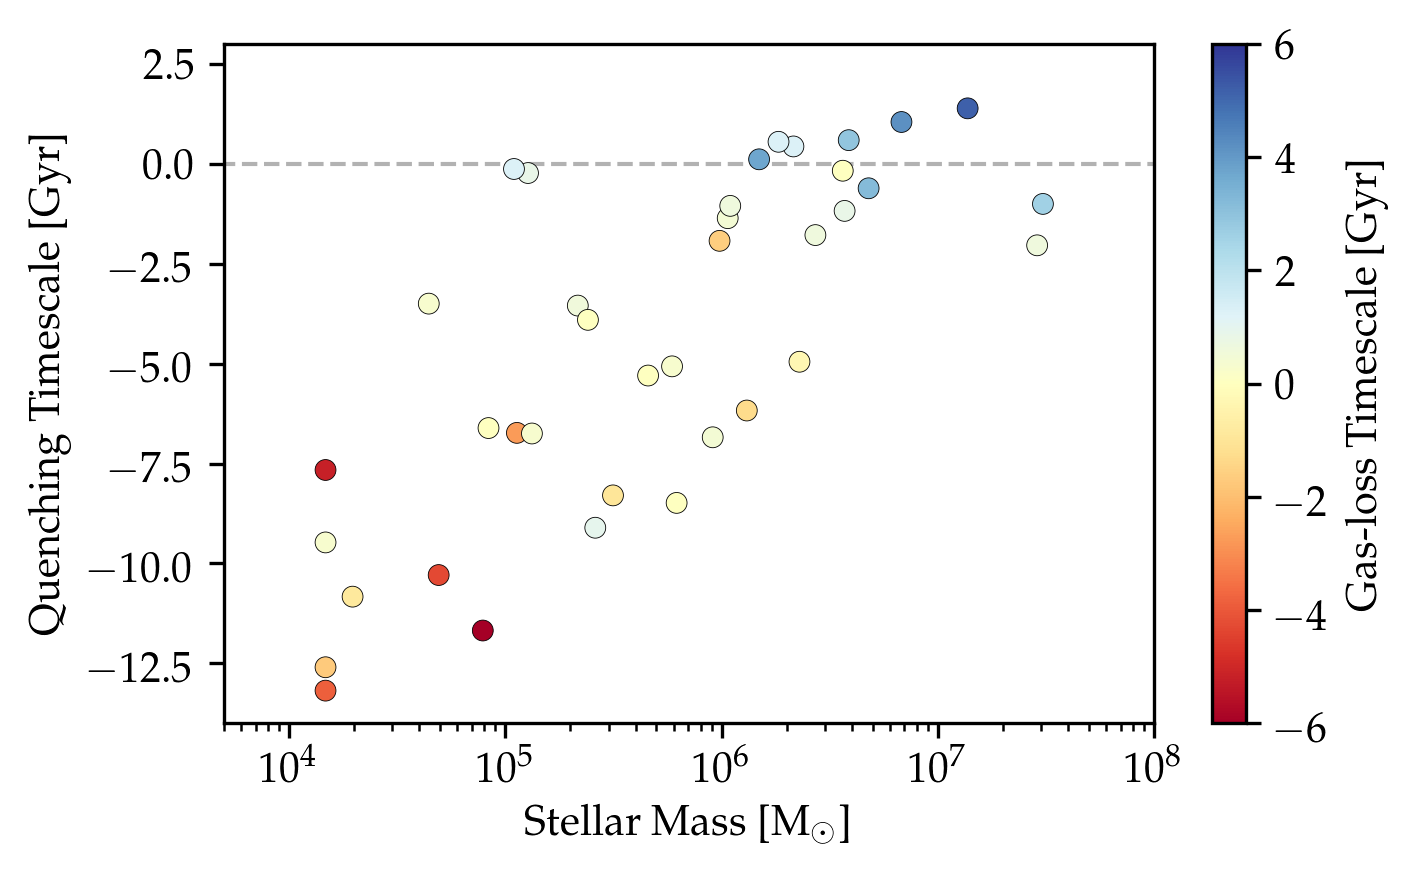

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

im = ax.scatter(mstar, tinfall-tquench,
                c=tinfall-tgasloss,
                s=25,
                cmap= 'RdYlBu',
                norm = mpl.colors.DivergingNorm(vmin=-6, vcenter=0, vmax=6),
                edgecolors='k',
                linewidths=0.2,
                zorder = 1)

# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Gas-loss Timescale [Gyr]')

ax.set_xlim(5e3,1e8)
ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=True,loc='lower right')
ax.semilogx()

plt.show()

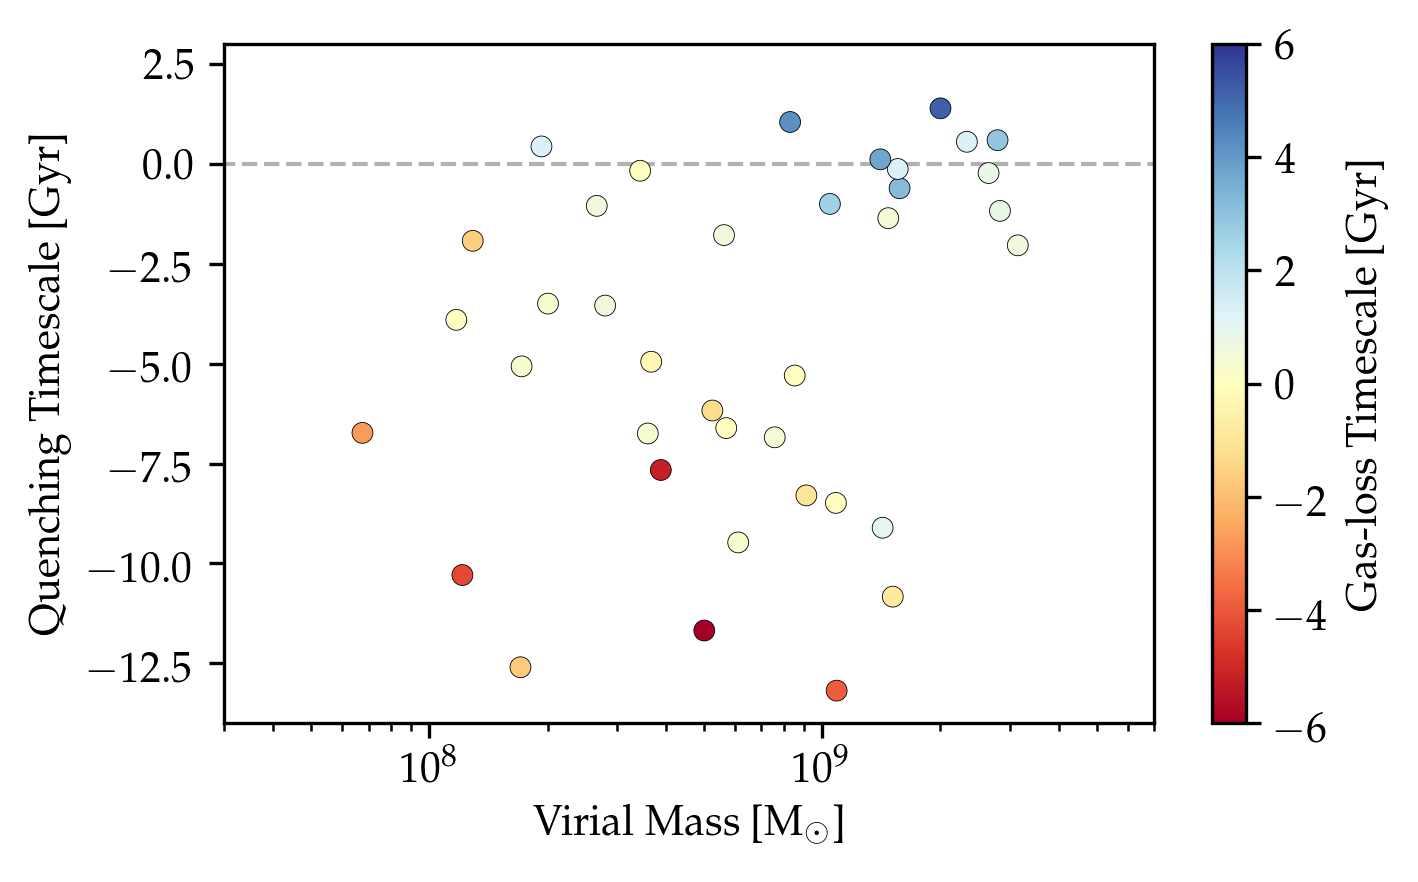

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

im = ax.scatter(mvir, tinfall-tquench,
                c=tinfall-tgasloss,
                s=25,
                cmap= 'RdYlBu',
                norm = mpl.colors.DivergingNorm(vmin=-6, vcenter=0, vmax=6),
                edgecolors='k',
                linewidths=0.2,
                zorder = 1)

# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)

cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Gas-loss Timescale [Gyr]')

ax.set_xlim(3e7,7e9)
ax.set_ylim(-14,3)

ax.set_xlabel('Virial Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=True,loc='lower right')
ax.semilogx()

plt.show()

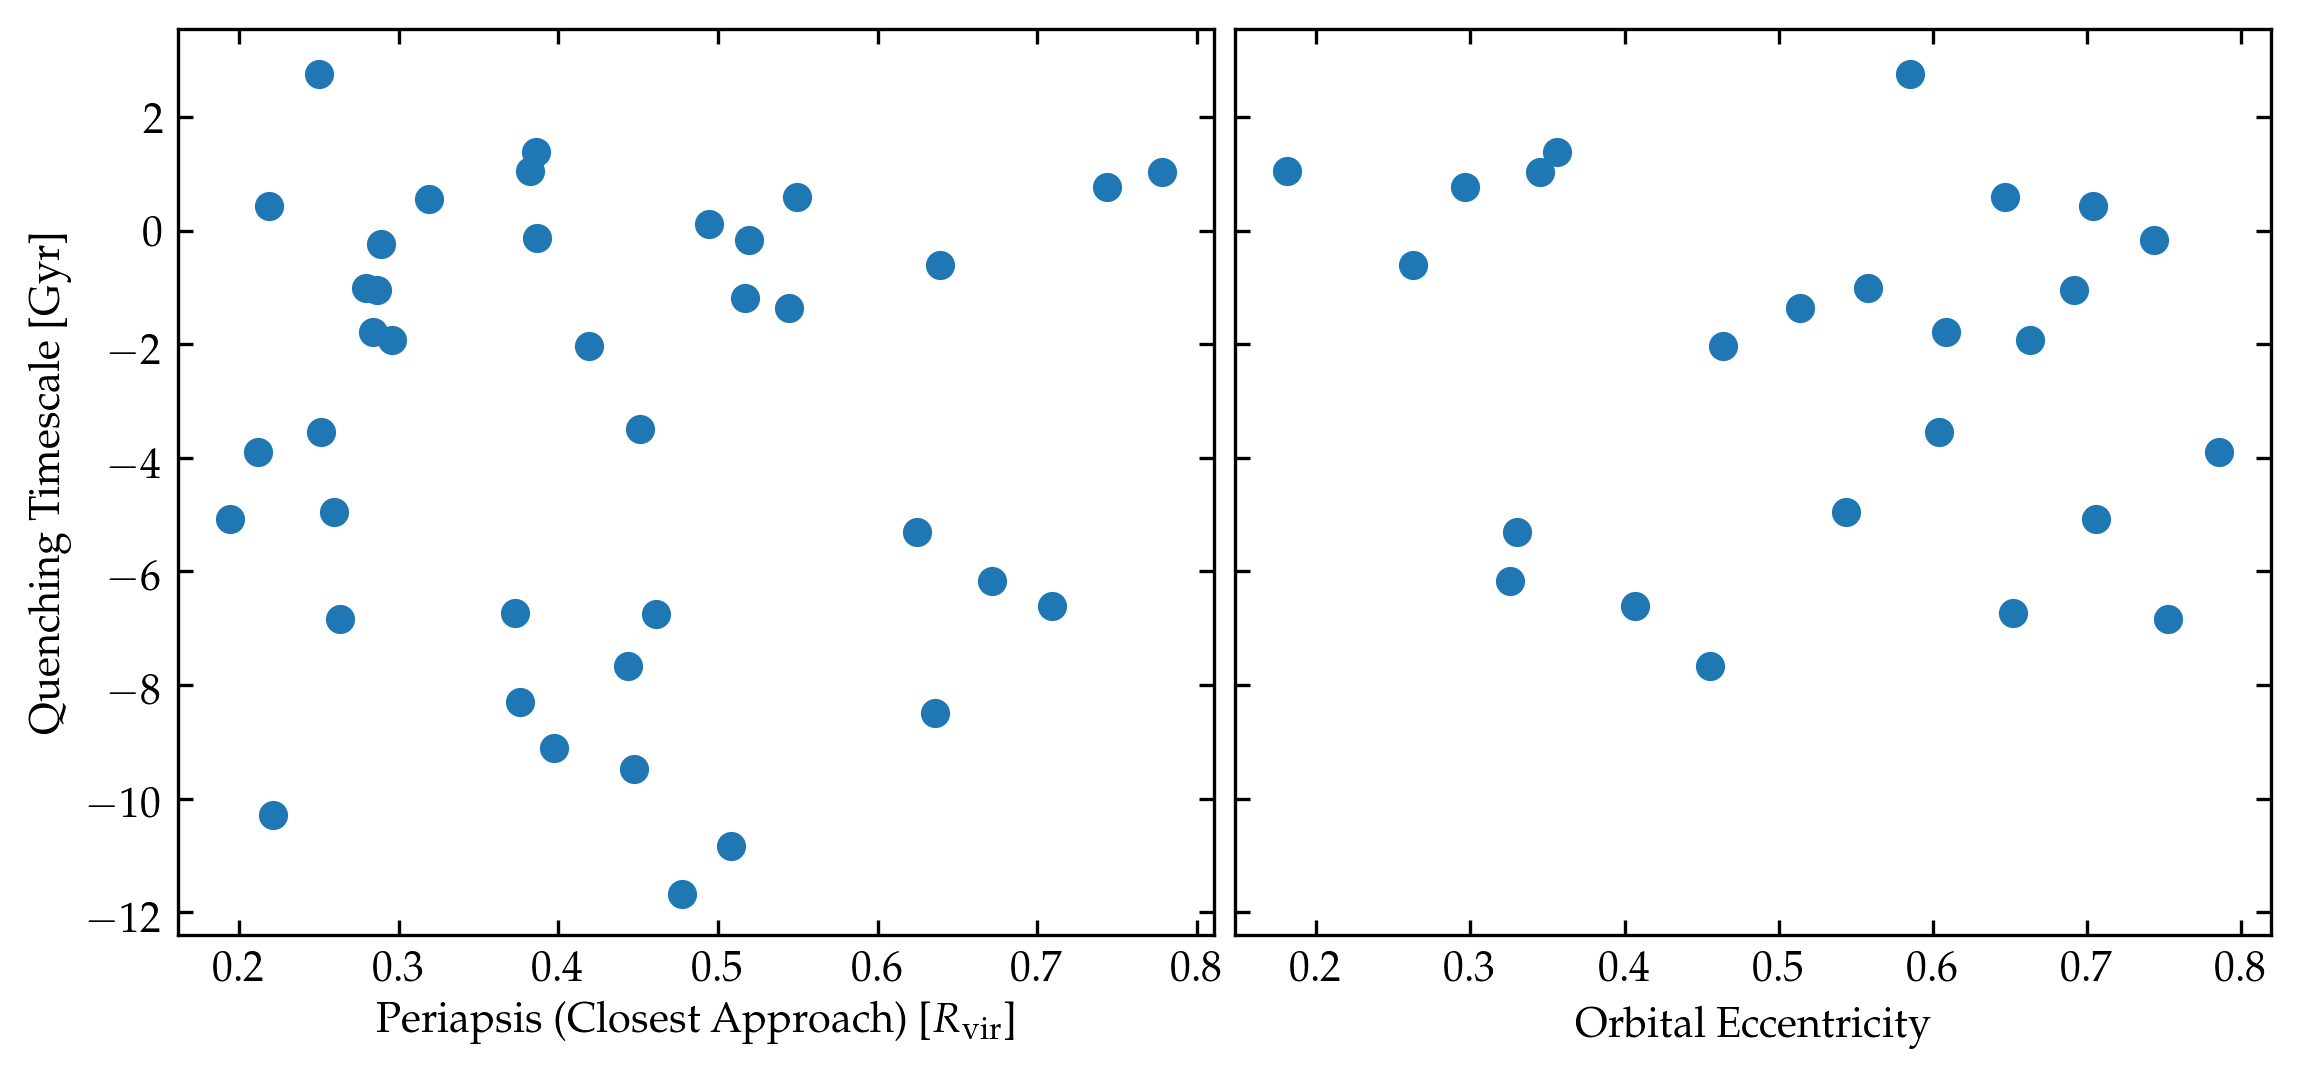

In [89]:
fig, ax = plt.subplots(1,2,figsize=(9,4),sharey=True, dpi=300)

ax[0].scatter(periapsis, tinfall-tquench)
ax[0].set_xlabel('Periapsis (Closest Approach) [$R_{\mathrm{vir}}$]')
ax[0].set_ylabel('Quenching Timescale [Gyr]')

ax[1].scatter(ecc, tinfall-tquench)
ax[1].set_xlabel('Orbital Eccentricity')

ax[0].tick_params(direction='in',which='both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[1].tick_params(direction='in',which='both')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

plt.subplots_adjust(wspace=0.02)
plt.show()

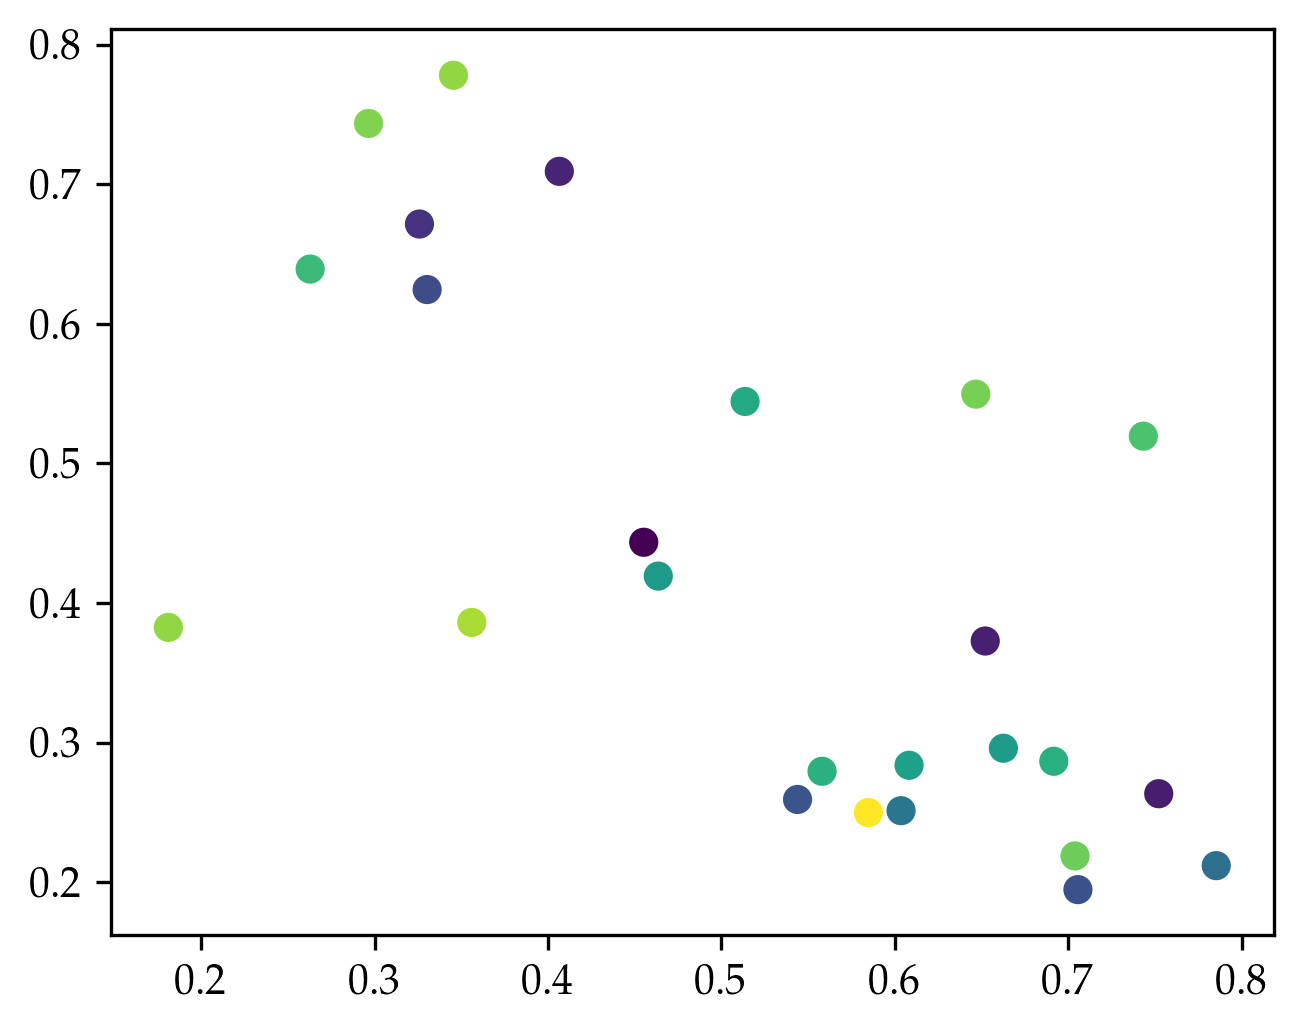

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,4),sharey=True, dpi=300)

ax.scatter(ecc, periapsis, c=np.array(tinfall-tquench))
# ax[0].set_xlabel('Periapsis (Closest Approach) [$R_{\mathrm{vir}}$]')
# ax[0].set_ylabel('Quenching Timescale [Gyr]')

# ax[1].scatter(ecc, tinfall-tquench)
# ax[1].set_xlabel('Orbital Eccentricity')

# ax[0].tick_params(direction='in',which='both')
# ax[0].yaxis.set_ticks_position('both')
# ax[0].xaxis.set_ticks_position('both')
# ax[1].tick_params(direction='in',which='both')
# ax[1].yaxis.set_ticks_position('both')
# ax[1].xaxis.set_ticks_position('both')

# plt.subplots_adjust(wspace=0.02)
plt.show()

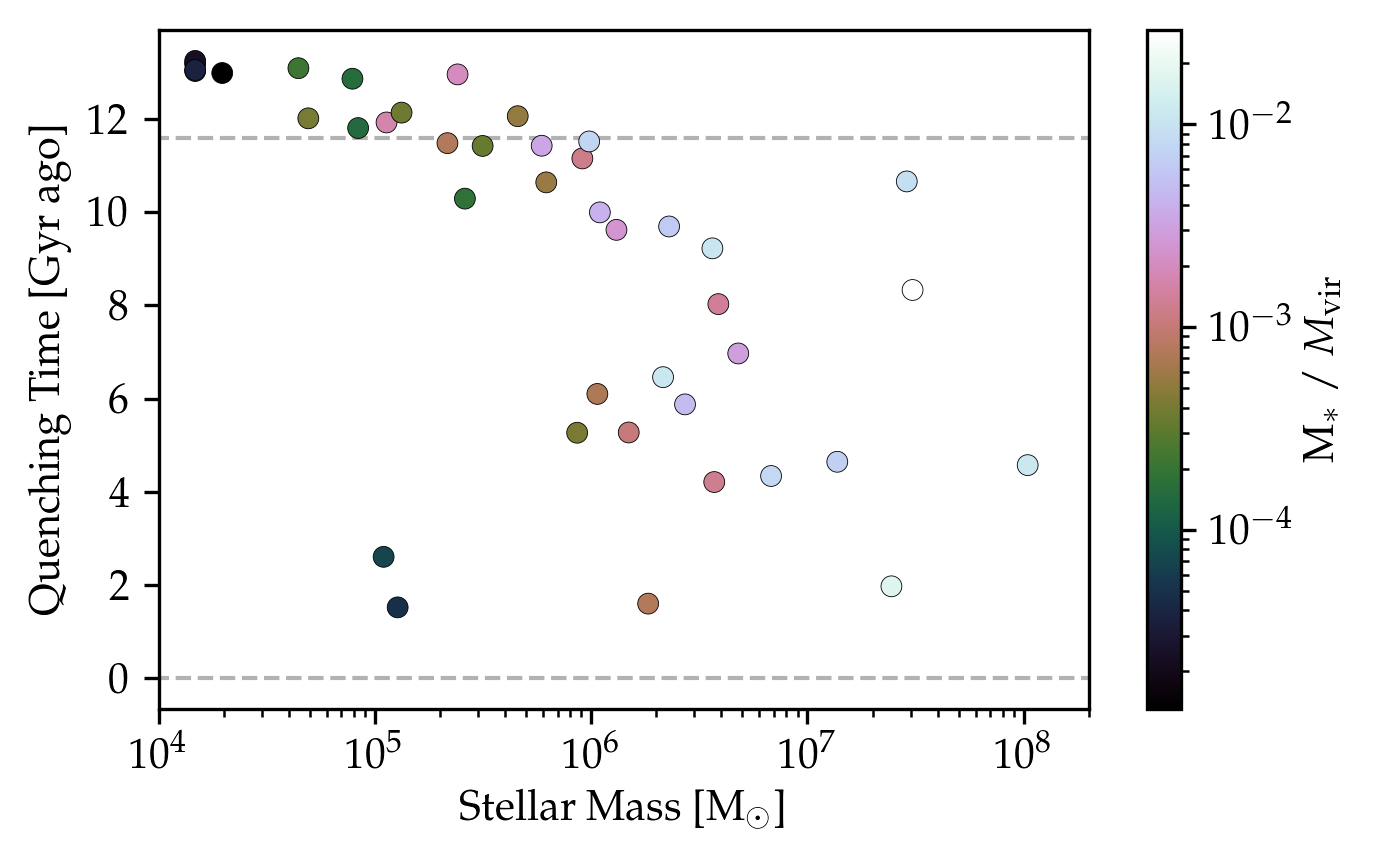

In [30]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=300)

im = ax.scatter(mstar, tquench,
                c=np.array(mstar/mvir),
                s=25,
                cmap= 'cubehelix',
                edgecolors='k',
                norm = mpl.colors.LogNorm(),
                linewidths=0.2,
                zorder = 1)

# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)
ax.plot([1e2, 1e10], [11.6,11.6], 'k--', linewidth=1, alpha=0.3, zorder=0)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'$\mathrm{M}_*\ /\ M_{\mathrm{vir}}$')

ax.set_xlim(1e4,2e8)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Time [Gyr ago]')
# ax.legend(frameon=True,loc='lower right')
ax.semilogx()

plt.show()